In [1]:
# Load standard modules
import os
import numpy as np
import json
import math
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import date, timedelta
import xarray as xr
import zarr
import glob
import cmocean as cm

# Pytorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torchvision import datasets, transforms

# cuda setup, set seed for reproducability 
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        
set_seed(41)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print(f"Using device: {device}")


# YOU NEED THIS TO LOAD PyTorch Lightning I DON"T KNOW WHY

from jupyter_client.manager import KernelManager
# Set torch dtype to float64
torch.set_default_dtype(torch.float64)

# Set model path
import sys
if os.path.exists('/home/tm3076/projects/NYU_SWOT_project/'):
    sys.path.append('/home/tm3076/projects/NYU_SWOT_project/Inpainting_Pytorch_gen/SWOT-inpainting-DL/src/')
else: 
    sys.path.append('/home.ufs/tm3076/swot_SUM03/SWOT_project/SWOT-inpainting-DL/src')
import simvip_model
import data_loaders
import interp_utils
import chatgpt_data_loaders


Using device: cpu


/ext3/miniforge3/envs/swot_python12_pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/ext3/miniforge3/envs/swot_python12_pytorch/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print(f"Using device: {device}")

Using device: cpu


In [3]:
import torch
for i in range(torch.cuda.device_count()):
   print(torch.cuda.get_device_properties(i))


#device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
if device == "cpu":
    n_cpus = 0
    multiprocessing = False
else:
    # Get available CPUs for parallel loading
    n_cpus = torch.get_num_threads()
    multiprocessing = True
print(f"Using device {device} on {n_cpus} cpus with multiprocessing={multiprocessing}")
device

Using device cpu on 10 cpus with multiprocessing=True


device(type='cpu')

In [4]:
m = [0,1]
a = np.random.randint(2)
print(a)
print(int((a-1)**2))

0
1


In [5]:

import wandb

In [6]:
wandb.login()

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tm3076 (tm3076-new-york-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [7]:
print(os.getcwd())

/scratch/projects/shaferlab/tatsu/NYU_SWOT_project/Inpainting_Pytorch_gen/Models/SimVip_May


In [8]:
from importlib import reload
simvip_model = reload(simvip_model)
data_loaders = reload(data_loaders)

# Choose the configuration you want to test here:


In [9]:
from hydra import initialize, compose
from omegaconf import OmegaConf

# Suppose your config folder is named 'conf' and is in the current working directory
config_path = "conf"
config_name = "021_C3_config_05rho"
config_name = "012_C1_config_07rho"
config_name = "002_C2_config_07rho"
# Initialize the Hydra config search path
with initialize(config_path=config_path):
    # Compose the configuration
    cfg = compose(config_name=config_name)
# Display the configuration nicely
print(OmegaConf.to_yaml(cfg))


outdir: ./outputs_SimVip_July
overall_model: SimVip_base
model_variant: 002_C2_config_07rho
data:
  dataset_path: /home/tm3076/scratch/pytorch_learning_tiles
  patch_coords_file: zarred_UVSST_x_y_coordinates_noland_nonan.npy
  infields:
  - zarr_llc4320_SSH_tiles_4km_filtered
  - zarr_llc4320_SST_tiles_4km
  outfields:
  - zarr_llc4320_SSH_tiles_4km_filtered
  in_mask_list:
  - nadir
  - cloud_rho
  out_mask_list:
  - swot_central
  in_transform_list:
  - std_global_mean_ssh_norm
  - std_global_mean_sst_norm
  out_transform_list:
  - std_global_mean_ssh_norm
  mean_ssh: 0
  std_ssh: 0.0453692672359483
  mean_sst: 15.956900367755182
  std_sst: 5.987649544923141
  N_t: 10
  timesteps_range:
  - 20
  - 360
  - 2
  batch_size: 30
  return_masks: false
  cloud_rho: 0.7
model:
  Number_timesteps: 10
  alpha0: 1
  alpha1: 10
  alpha2: 10
  lr: 1.0e-05
  drop: 0.2
  drop_path: 0.15
  model_type: gSTA
  multiprocessing: true
  masked_loss: true
training:
  num_epochs: 100
  checkpoint_dir: chec

In [10]:
cfg.wandb.get("model_name")

'002_C2_config_07rho_2025-07-21_18-15-30'

In [11]:
cfg["model_variant"]

'002_C2_config_07rho'

# Define the dataloaders

In [12]:
data_loaders = reload(data_loaders)

In [13]:
DATASET_PATH = cfg.data.get("dataset_path",)
if os.path.exists('/home/tm3076/projects/NYU_SWOT_project/'):
    cfg.data["dataset_path"] = "/home/tm3076/scratch/pytorch_learning_tiles"
else: 
    cfg.data["dataset_path"] = "/home.ufs/tm3076/swot_SUM03/pytorch_learning_tiles"


In [14]:
cfg.data["dataset_path"]

'/home/tm3076/scratch/pytorch_learning_tiles'

In [15]:
n_cpus = torch.get_num_threads()
n_cpus

10

In [16]:
DATASET_PATH

'/home/tm3076/scratch/pytorch_learning_tiles'

In [132]:
data_loaders = reload(data_loaders)
chatgpt_data_loaders = reload(chatgpt_data_loaders)

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# Modules for loading data, set data pathimport urllib
DATASET_PATH = cfg.data["dataset_path"] 
CHECKPOINT_PATH = cfg.training["checkpoint_dir"]

N_t = cfg.data["N_t"]
# Input fields
infields = cfg.data["infields"]#["zarr_llc4320_SST_tiles_4km","zarr_llc4320_SSH_tiles_4km_filtered"]#
outfields = cfg.data["outfields"]#None#["zarr_llc4320_SSH_tiles_4km_filtered"]#
in_mask_list = cfg.data["in_mask_list"]#[None]#[None]*len(infields)#
out_mask_list = cfg.data["out_mask_list"]#[None]#[None]*len(outfields)#
# Pre-computed global normalisation stats and transforms
in_transform_list = cfg.data["in_transform_list"]
out_transform_list = cfg.data["out_transform_list"]
cloud_rho = cfg.data["cloud_rho"]

# Prepare standards for transforms
standards = {
            "mean_ssh":  cfg.data["mean_ssh"], "std_ssh": cfg.data["std_ssh"],
            "mean_sst": cfg.data["mean_sst"], "std_sst": cfg.data["std_sst"]
            }

if os.path.exists('/home/tm3076/projects/NYU_SWOT_project/'):
    patch_coords = zarr.load(f'{DATASET_PATH}/x_y_coordinates_noland.zarr')
else: 
    patch_coords = np.load(f'{DATASET_PATH}/zarred_UVSST_x_y_coordinates_noland_nonan.npy')
    
batch_size = 5#cfg.data["batch_size"]



    
# Data loader 
full_dataset = torch.utils.data.ConcatDataset([chatgpt_data_loaders.llc4320_dataset(DATASET_PATH, i_mid_timestep, N_t, patch_coords, 
                                                                            infields, outfields, in_mask_list, out_mask_list, 
                                                                            in_transform_list, out_transform_list, standards=standards,
                                                                            cloud_rho=cloud_rho, return_metadata=False,
                                                                            time_loading=False
                                                                           ) for i_mid_timestep in range(30,360,5)])

# Split into train, validation, and test data
train_length = int(0.7*len(full_dataset))
validation_length = int(0.2*len(full_dataset))
test_length = len(full_dataset) - train_length - validation_length
train_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(full_dataset, (train_length, validation_length, test_length))

# Verify size of datasets
print(f"size train_dataset: {len(train_dataset)}")
print(f"size validation_dataset: {len(validation_dataset)}")
print(f"size test_dataset: {len(test_dataset)}")

def worker_init_fn(worker_id):
    np.random.seed(torch.initial_seed() % (2**32))
    #worker_info = torch.utils.data.get_worker_info()


def fast_collate(batch):
    invar = torch.stack([b[0] for b in batch], dim=0)
    outvar = torch.stack([b[1] for b in batch], dim=0)
    return invar, outvar

data_loader_kwargs = {"shuffle":True,
                      "batch_size":batch_size,
                      "num_workers":5,
                      "worker_init_fn":worker_init_fn,
                      "persistent_workers":False,#multiprocessing,
                      "pin_memory":False,
                     #"multiprocessing_context":'spawn'
                      #"collate_fn":fast_collate,
                     }
train_data_loader = DataLoader(train_dataset,**data_loader_kwargs)
val_data_loader   = DataLoader(validation_dataset, **data_loader_kwargs)
test_data_loader  = DataLoader(test_dataset,**data_loader_kwargs)






size train_dataset: 16678
size validation_dataset: 4765
size test_dataset: 2383


In [133]:
outfields=None
if outfields:
    print("yes")

In [133]:
for x, y in train_data_loader:
    break

In [129]:
import cProfile
import pstats

In [130]:
import cProfile

def test_dataloader():
    for x in train_data_loader:
        break
    return x

In [131]:
cProfile.run('test_dataloader()', sort='cumtime')

         1908832 function calls (1858313 primitive calls) in 3.993 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      843    0.002    0.000    7.125    0.008 local.py:138(queue_get)
      843    0.004    0.000    7.039    0.008 queue.py:154(get)
      2/1    0.000    0.000    3.982    3.982 {built-in method builtins.exec}
      2/1    0.000    0.000    3.982    3.982 <string>:1(<module>)
      2/1    0.000    0.000    3.982    3.982 2007635004.py:3(test_dataloader)
      2/1    0.000    0.000    3.982    3.982 dataloader.py:703(__next__)
      2/1    0.000    0.000    3.982    3.982 dataloader.py:762(_next_data)
      2/1    0.000    0.000    3.982    3.982 fetch.py:47(fetch)
      2/1    0.000    0.000    3.981    3.981 dataset.py:414(__getitems__)
      6/5    0.000    0.000    3.940    0.788 dataset.py:338(__getitem__)
        5    0.001    0.000    3.940    0.788 chatgpt_data_loaders.py:54(__getitem__)
       10   

## Verify Dataloader is working as expected

In [90]:
PATH = "/scratch/projects/shaferlab/tatsu/NYU_SWOT_project/Inpainting_Pytorch_gen/SWOT-inpainting-DL/data"
daily_climatology = xr.open_dataset(f"{PATH}/SST_NP_daily_climatology.nc")

SSH swath std tensor(0.2809, dtype=torch.float32)
SST truth std tensor(0.5482, dtype=torch.float32)
SSH truth std tensor(0.8684)


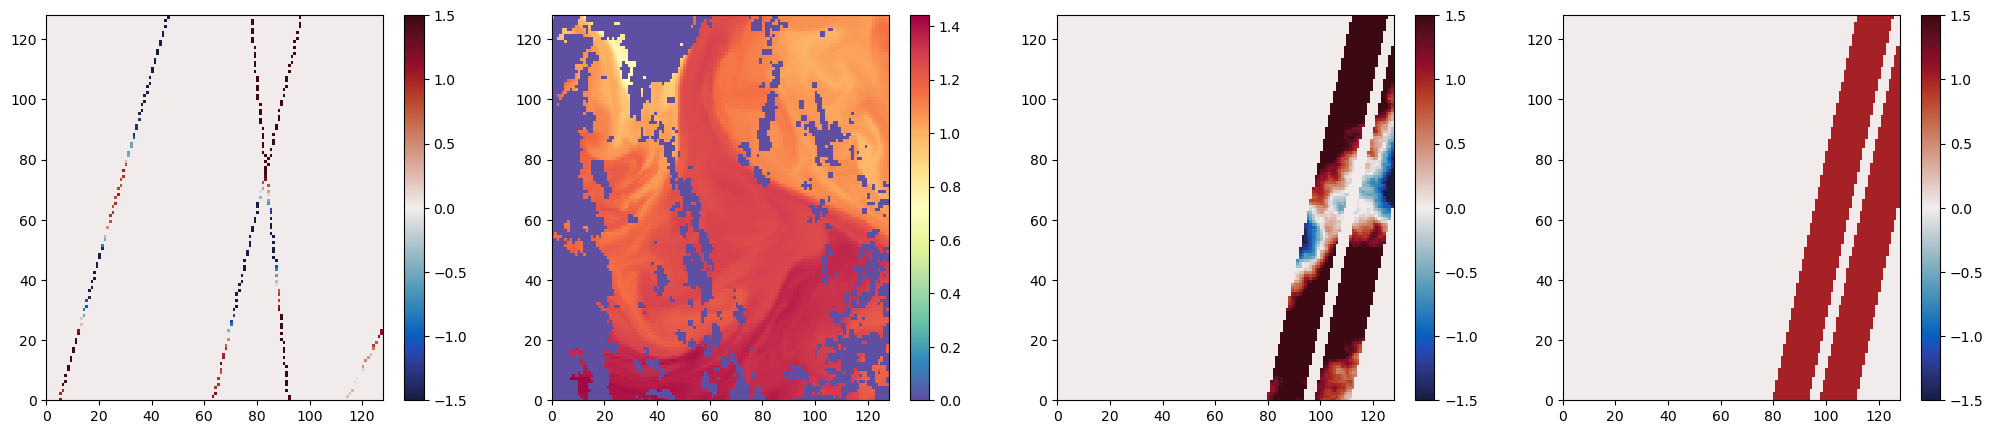

SSH swath std tensor(0.0569, dtype=torch.float32)
SST truth std tensor(0.2718, dtype=torch.float32)
SSH truth std tensor(0.1488)


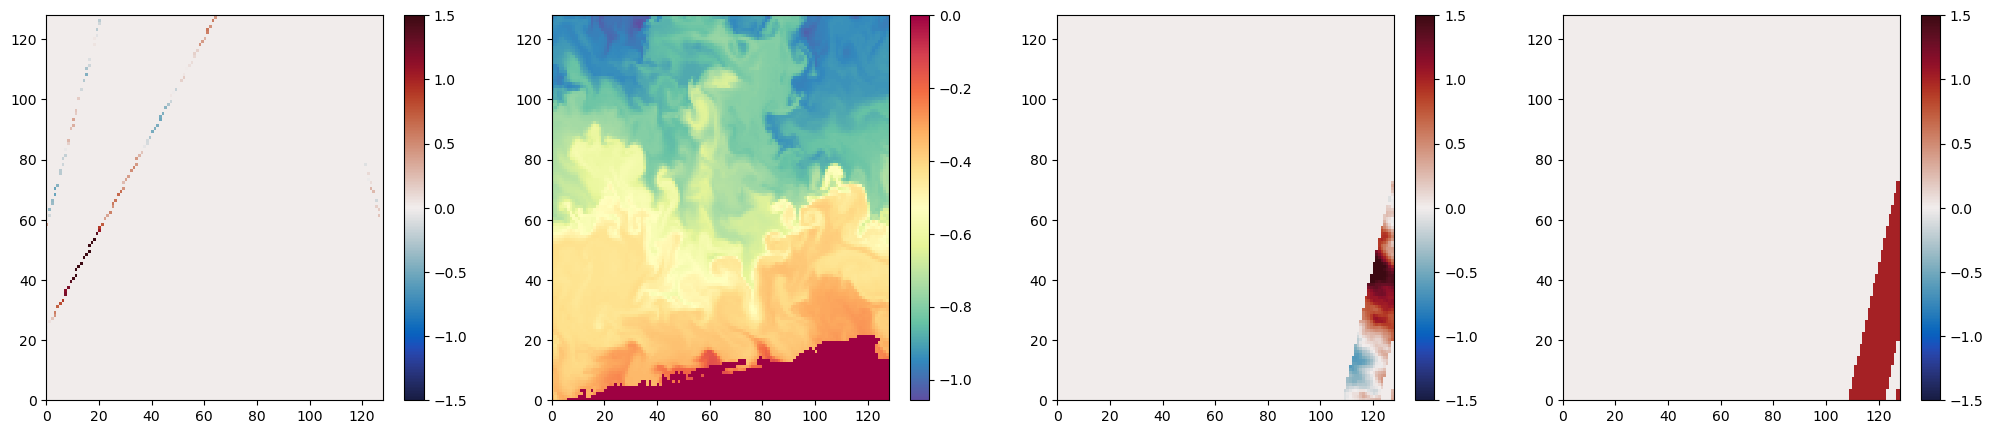

SSH swath std tensor(0., dtype=torch.float32)
SST truth std tensor(0.3614, dtype=torch.float32)
SSH truth std tensor(0.3103)


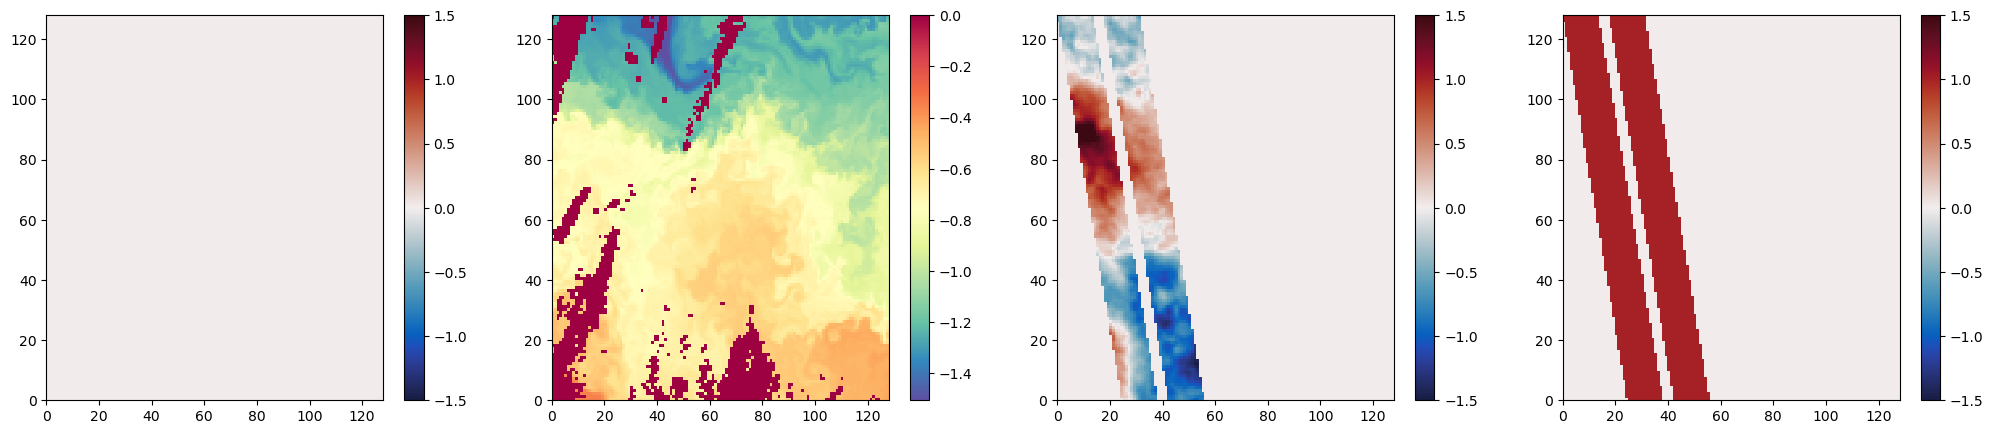

SSH swath std tensor(0.2047, dtype=torch.float32)
SST truth std tensor(0.4602, dtype=torch.float32)
SSH truth std tensor(0.6311)


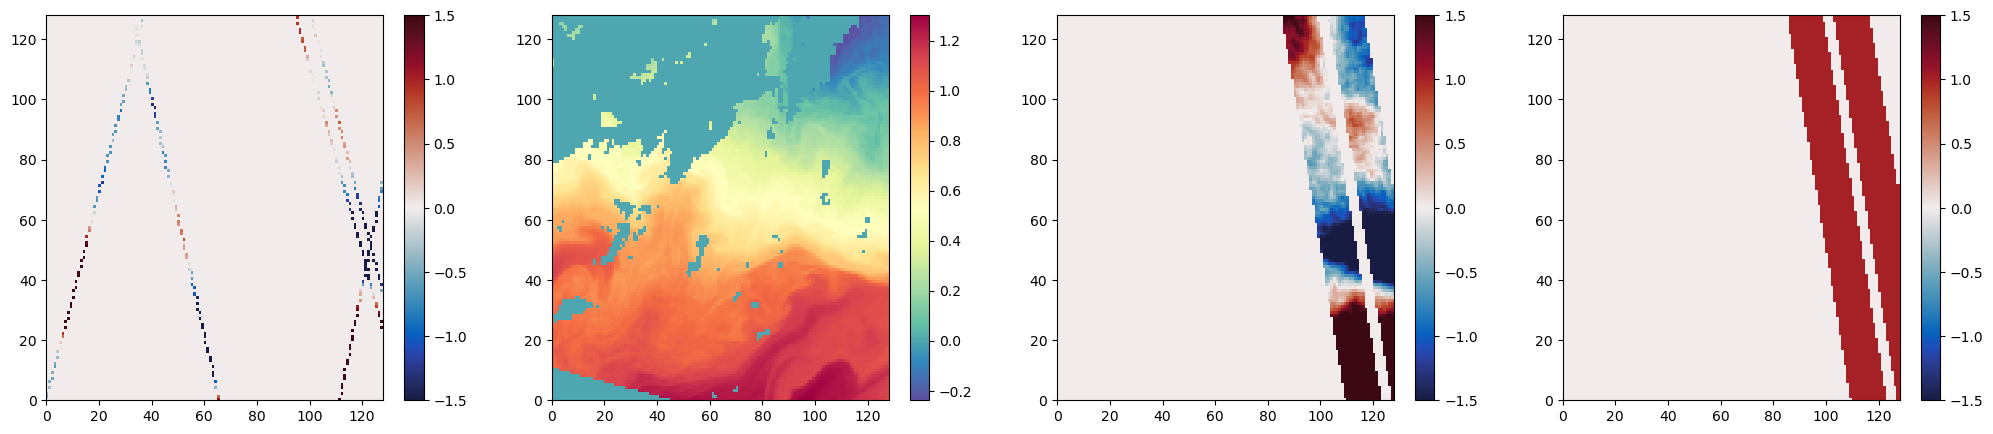

SSH swath std tensor(0.1557, dtype=torch.float32)
SST truth std tensor(0.9052, dtype=torch.float32)
SSH truth std tensor(0.2816)


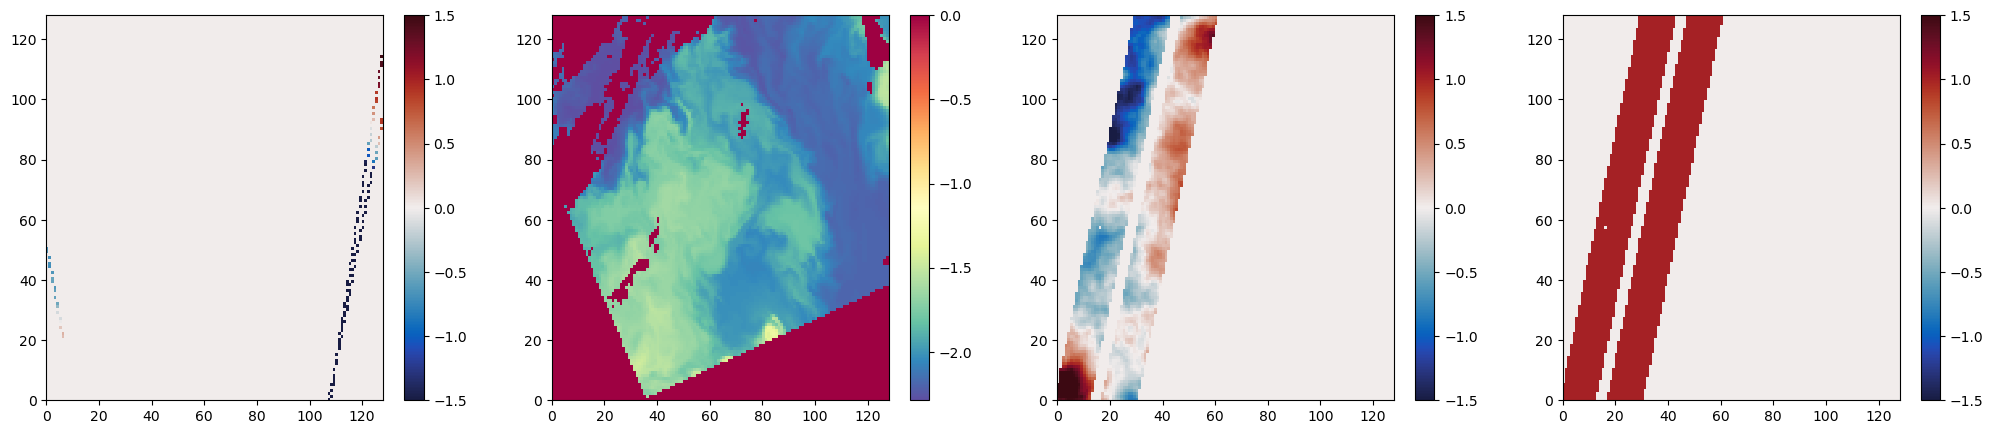

SSH swath std tensor(0.1546, dtype=torch.float32)
SST truth std tensor(0.5752, dtype=torch.float32)
SSH truth std tensor(0.3343)


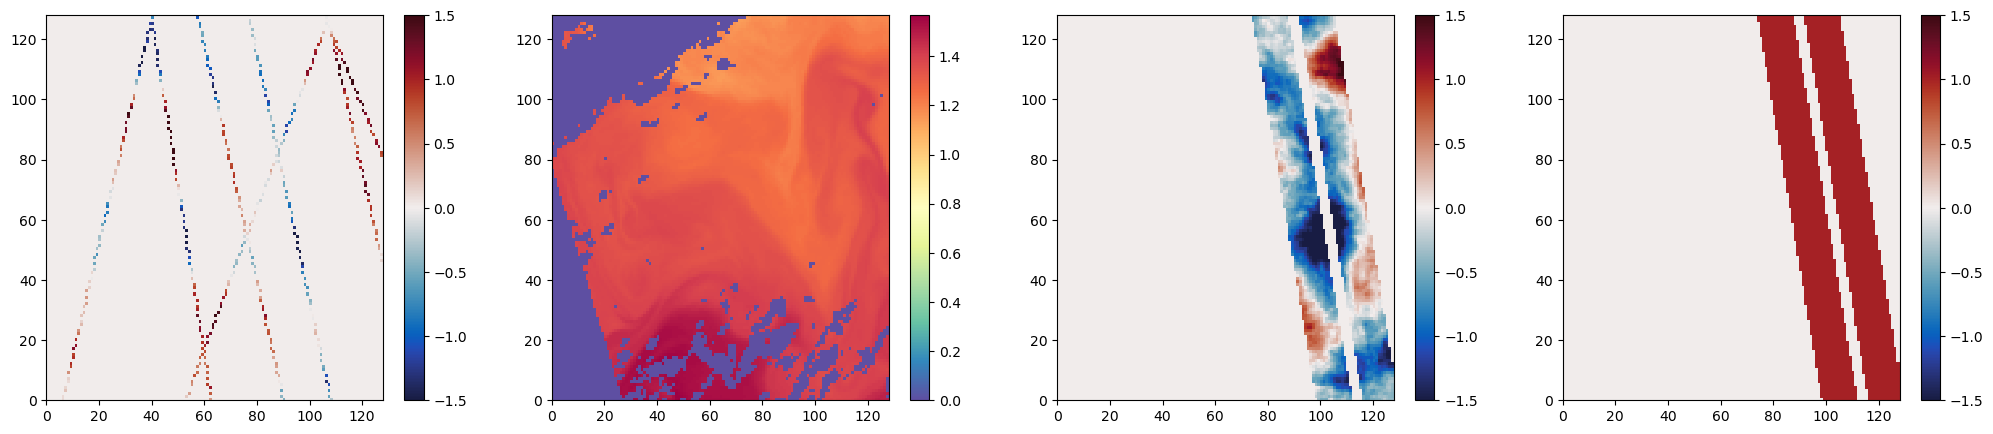

SSH swath std tensor(0.0446, dtype=torch.float32)
SST truth std tensor(0.6787, dtype=torch.float32)
SSH truth std tensor(0.1618)


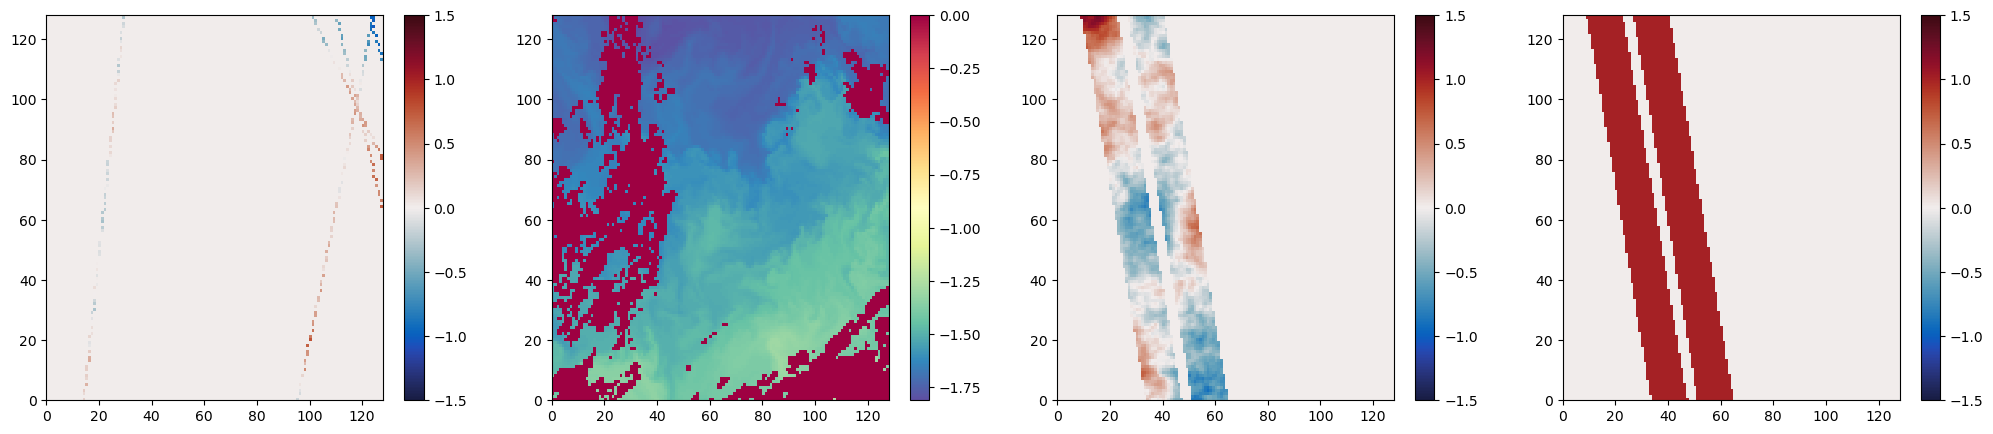

SSH swath std tensor(0.1390, dtype=torch.float32)
SST truth std tensor(0.4938, dtype=torch.float32)
SSH truth std tensor(0.3343)


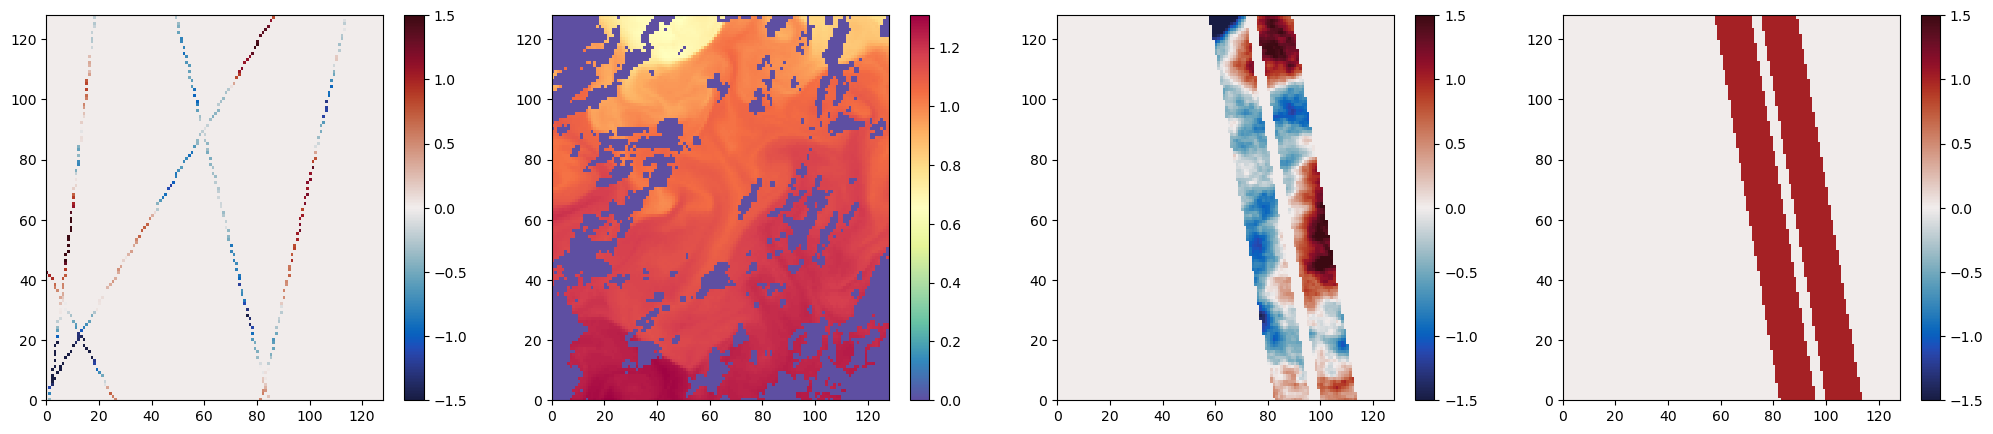

SSH swath std tensor(0.1074, dtype=torch.float32)
SST truth std tensor(0.2369, dtype=torch.float32)
SSH truth std tensor(0.3859)


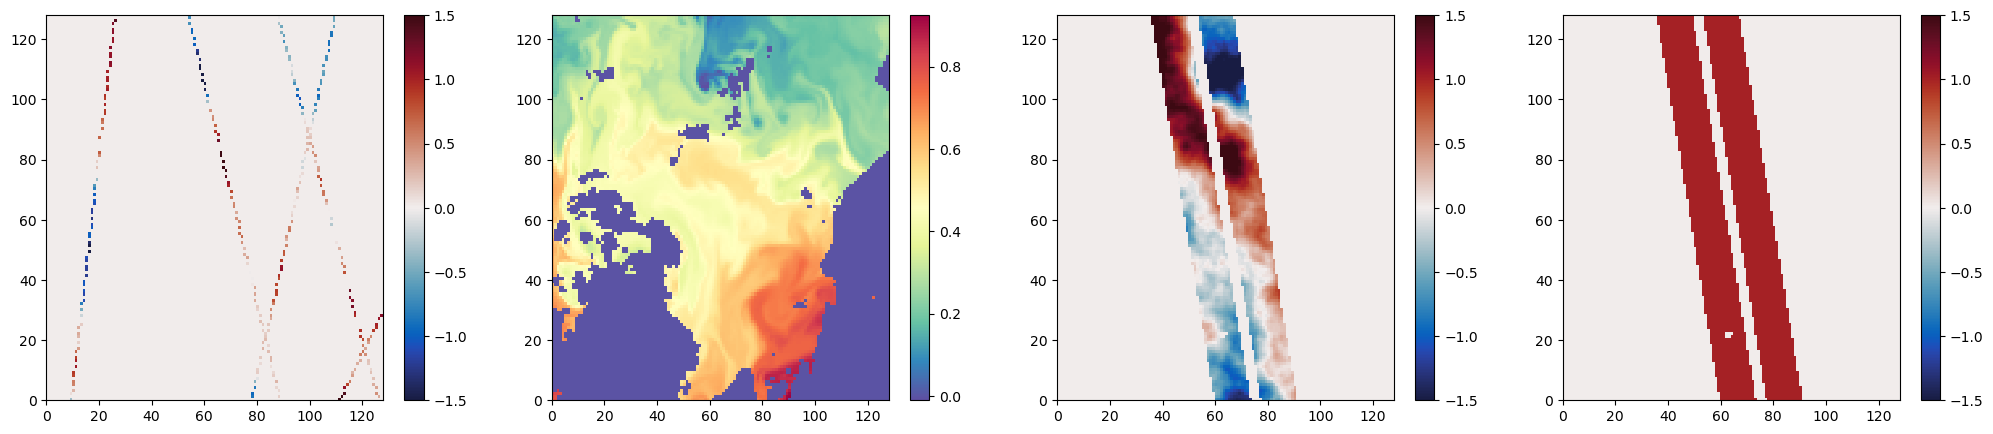

SSH swath std tensor(0.2007, dtype=torch.float32)
SST truth std tensor(0.6561, dtype=torch.float32)
SSH truth std tensor(0.5875)


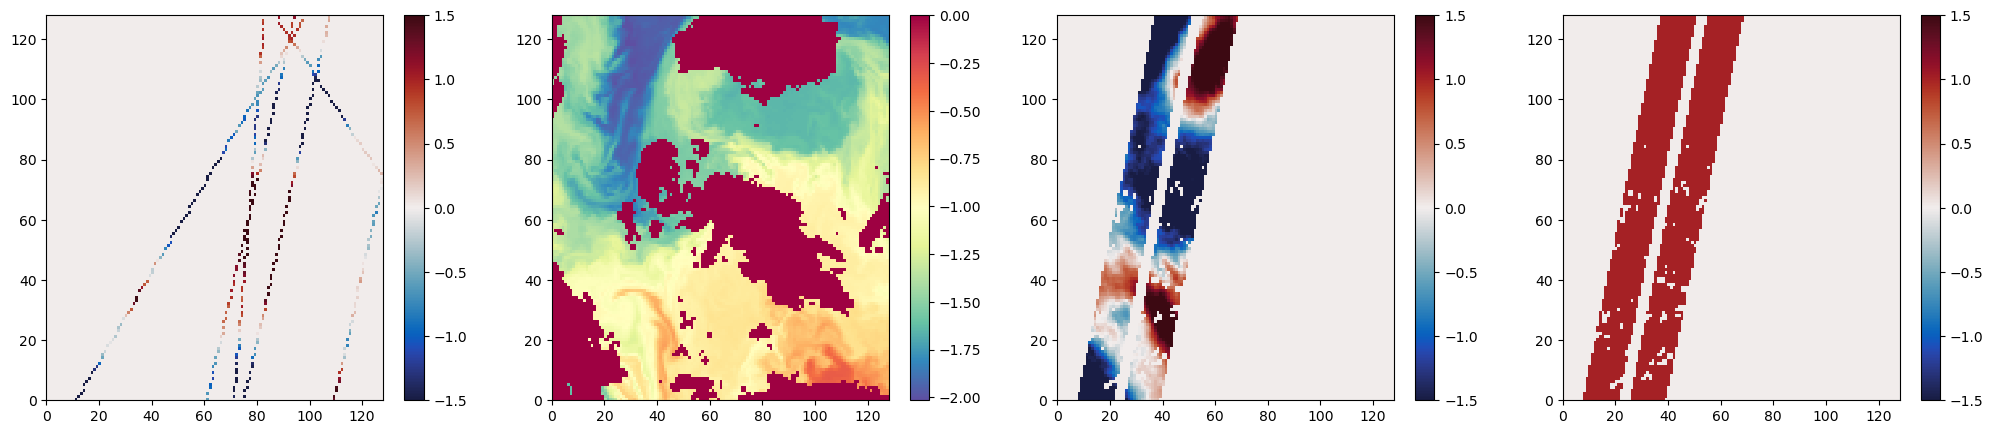

SSH swath std tensor(0.0238, dtype=torch.float32)
SST truth std tensor(0.1607, dtype=torch.float32)
SSH truth std tensor(0.2002)


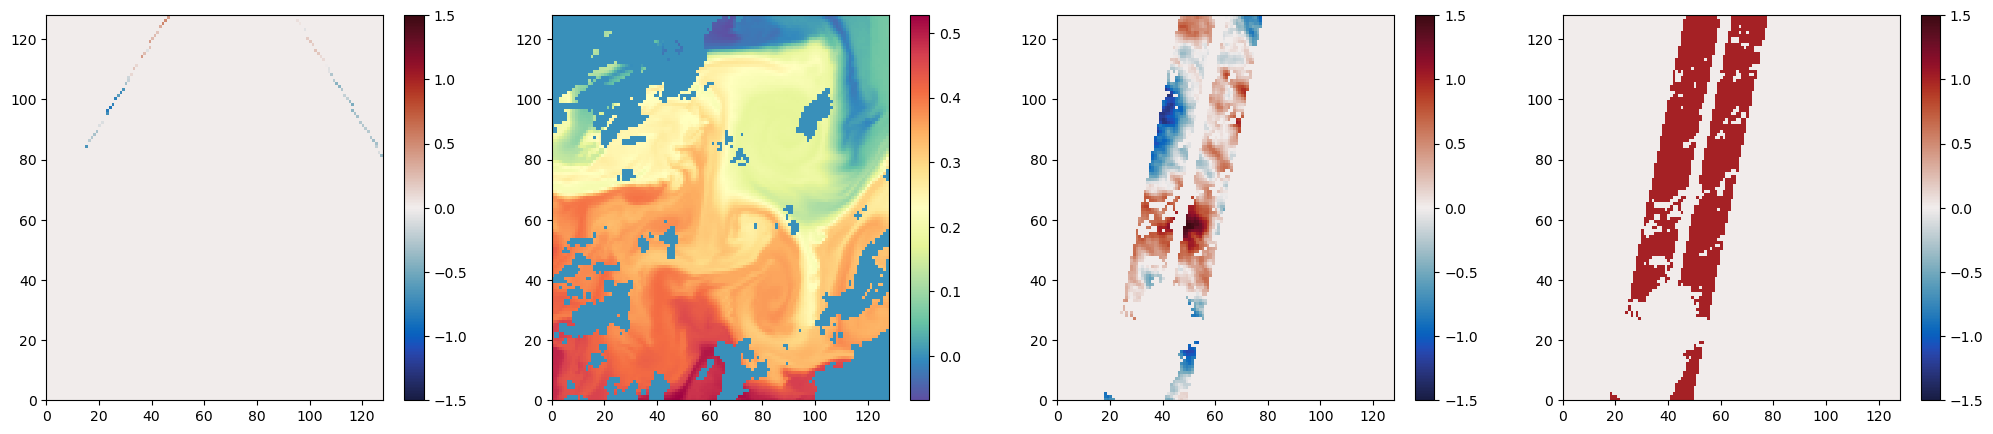

SSH swath std tensor(0., dtype=torch.float32)
SST truth std tensor(0.2567, dtype=torch.float32)
SSH truth std tensor(1.5488)


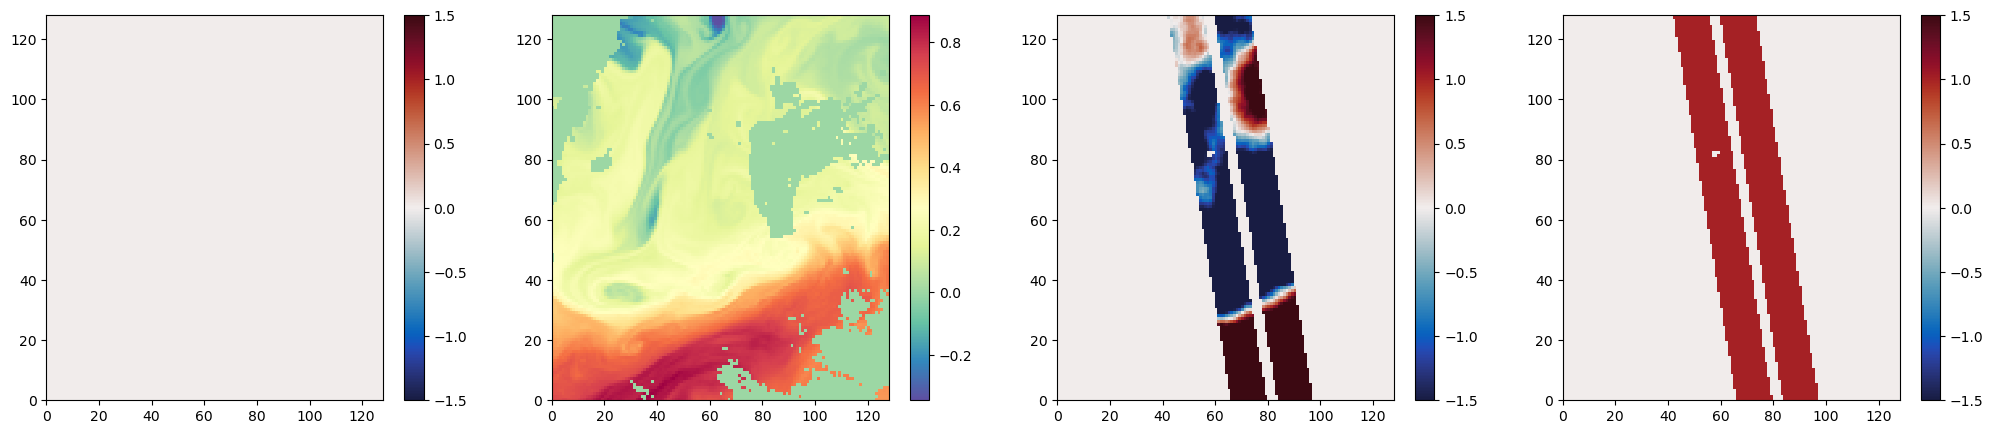

SSH swath std tensor(0.0529, dtype=torch.float32)
SST truth std tensor(0.4523, dtype=torch.float32)
SSH truth std tensor(0.3293)


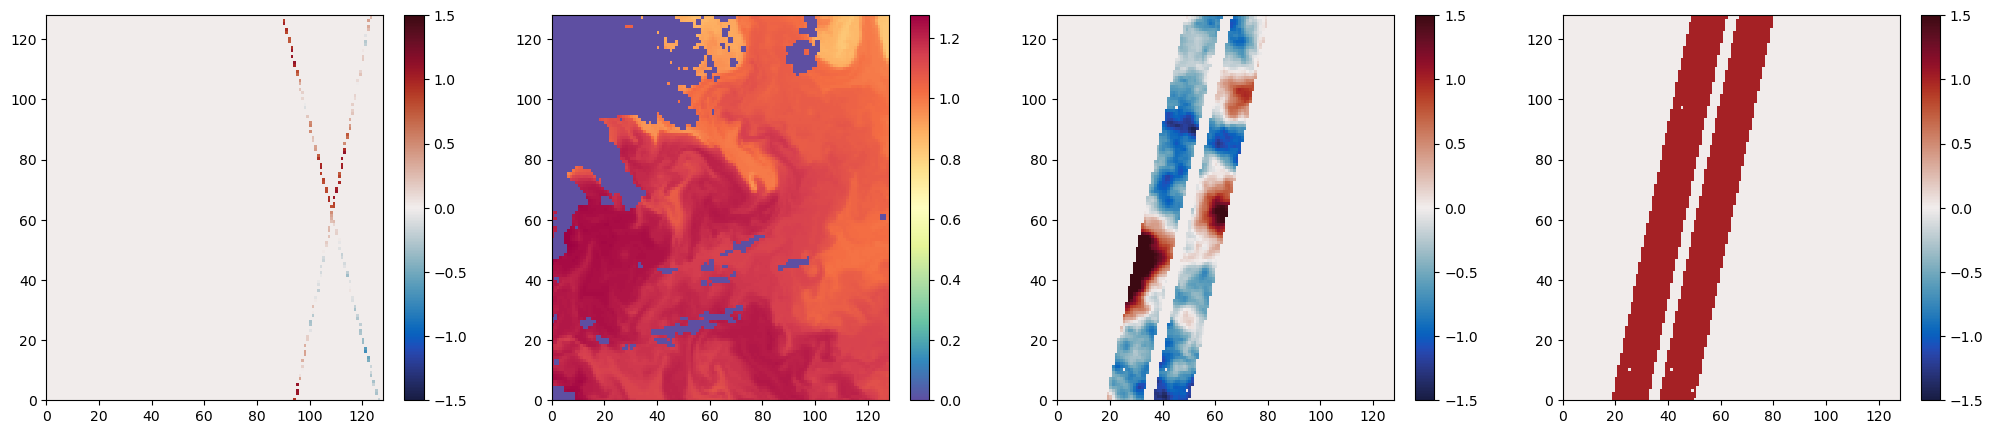

SSH swath std tensor(0.0367, dtype=torch.float32)
SST truth std tensor(0.3788, dtype=torch.float32)
SSH truth std tensor(0.2006)


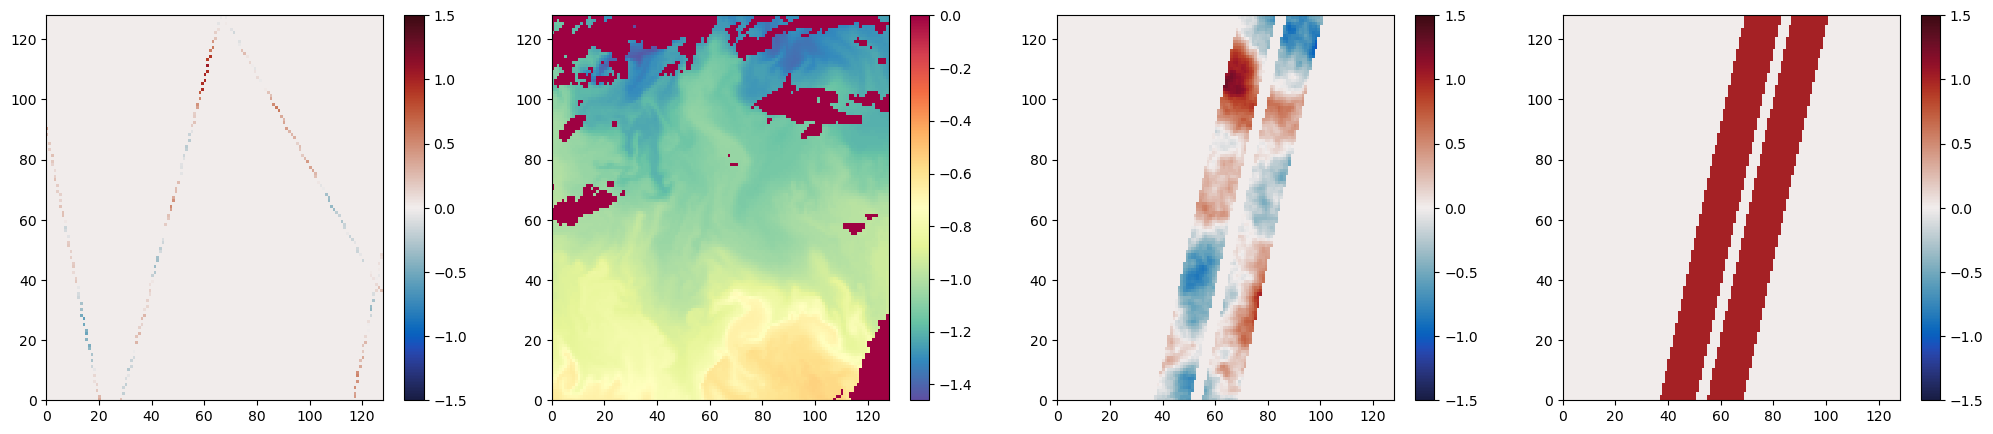

SSH swath std tensor(0.0655, dtype=torch.float32)
SST truth std tensor(0.1464, dtype=torch.float32)
SSH truth std tensor(0.1969)


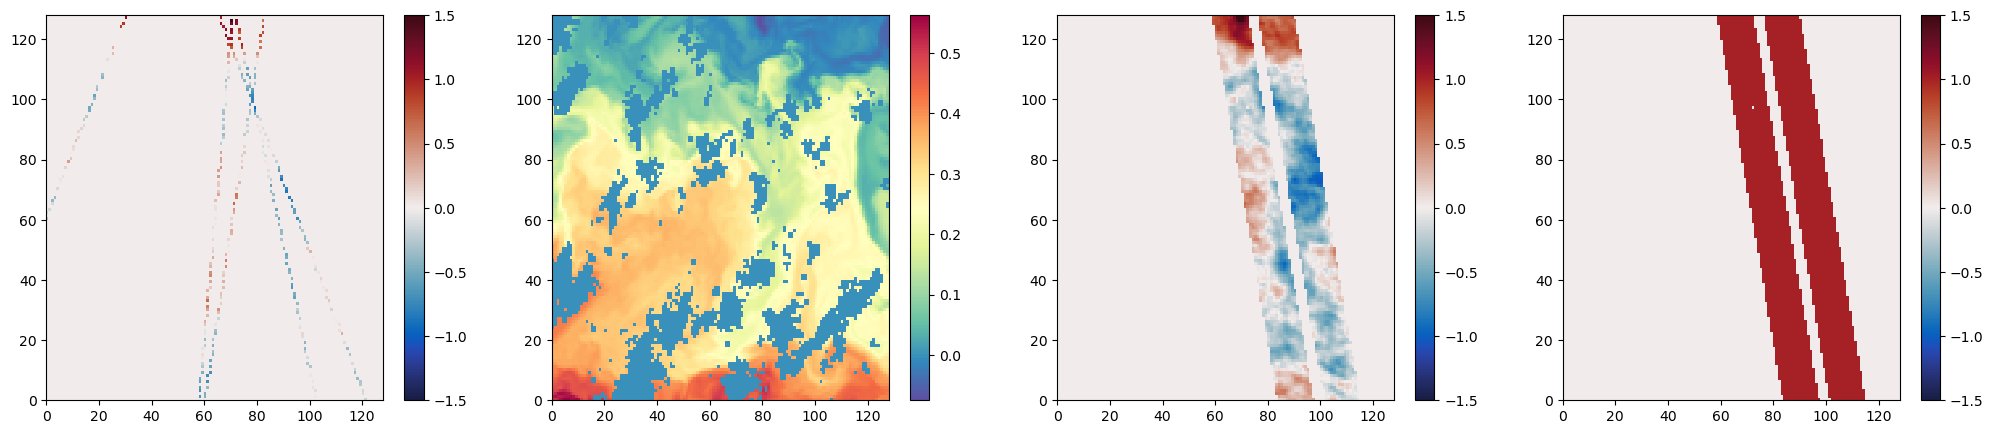

SSH swath std tensor(0.0926, dtype=torch.float32)
SST truth std tensor(0.3939, dtype=torch.float32)
SSH truth std tensor(0.0892)


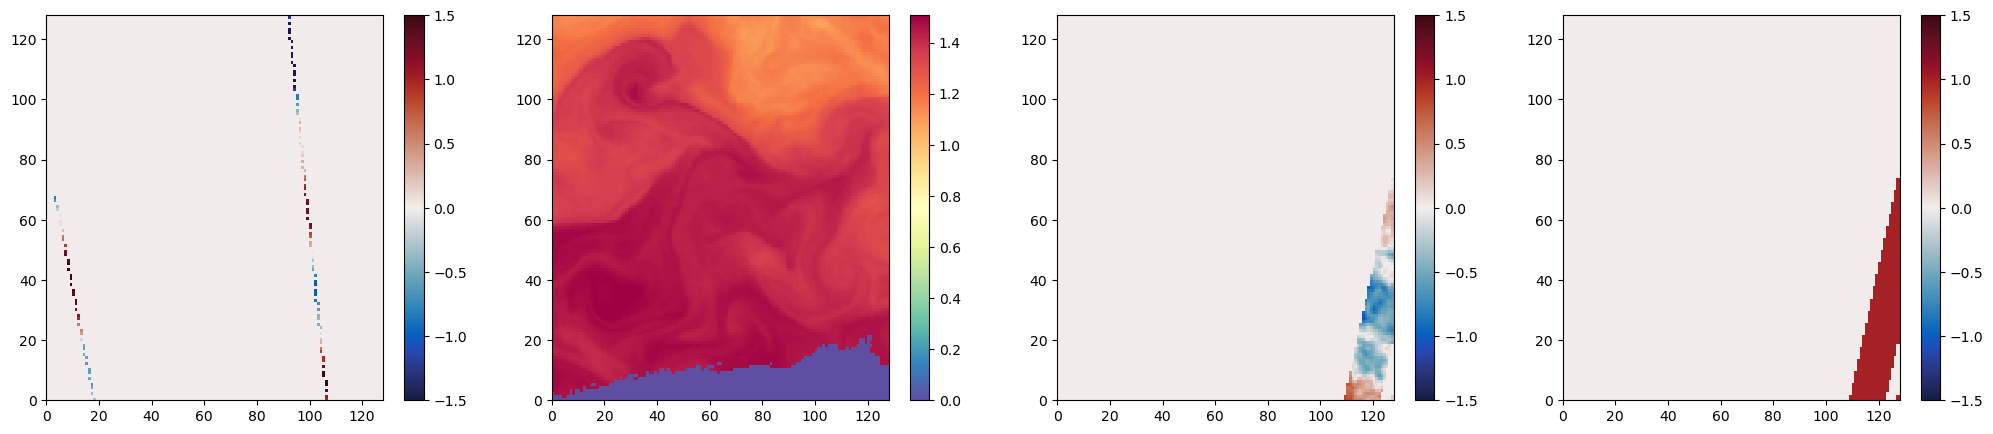

SSH swath std tensor(0.0860, dtype=torch.float32)
SST truth std tensor(0.6437, dtype=torch.float32)
SSH truth std tensor(0.3897)


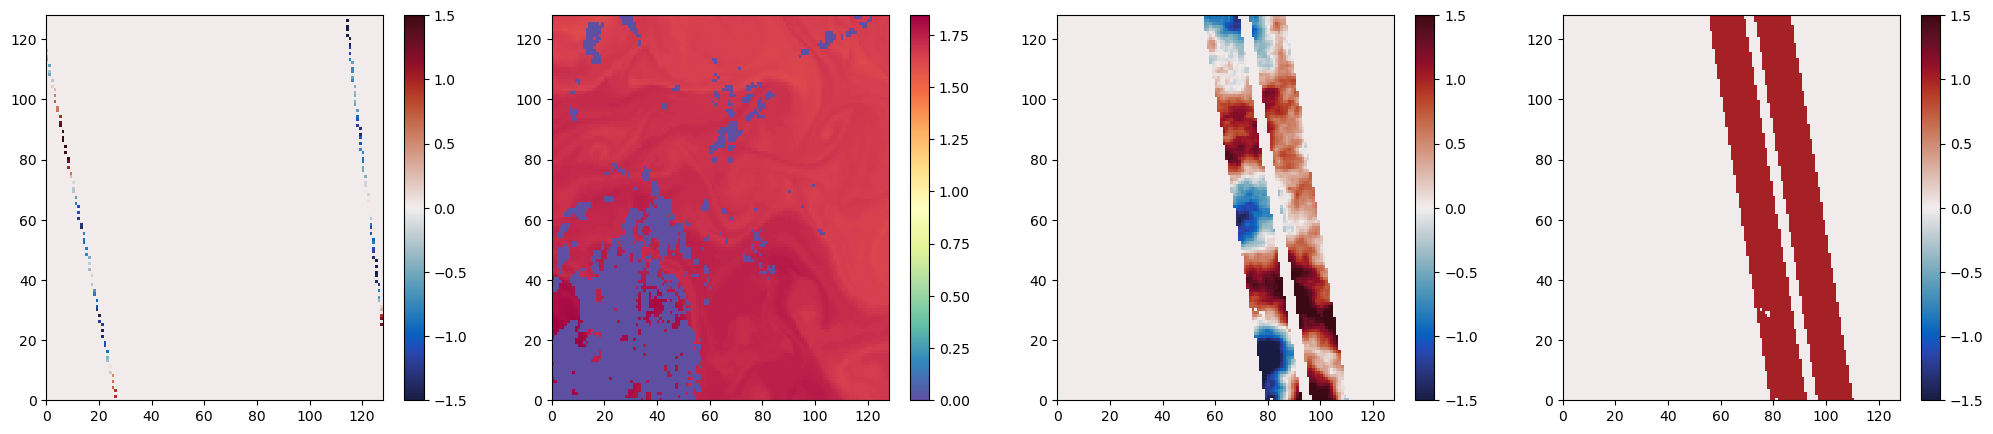

SSH swath std tensor(0.0494, dtype=torch.float32)
SST truth std tensor(0.1487, dtype=torch.float32)
SSH truth std tensor(0.1023)


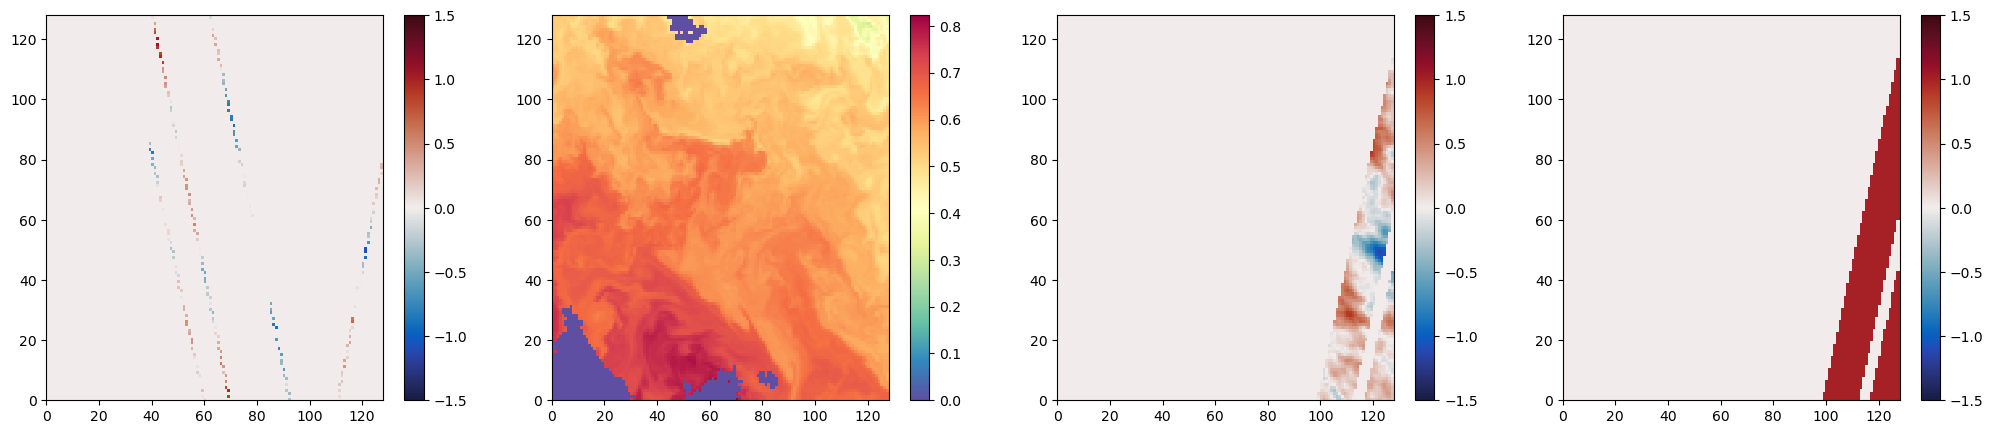

SSH swath std tensor(0.1139, dtype=torch.float32)
SST truth std tensor(0.2990, dtype=torch.float32)
SSH truth std tensor(0.1803)


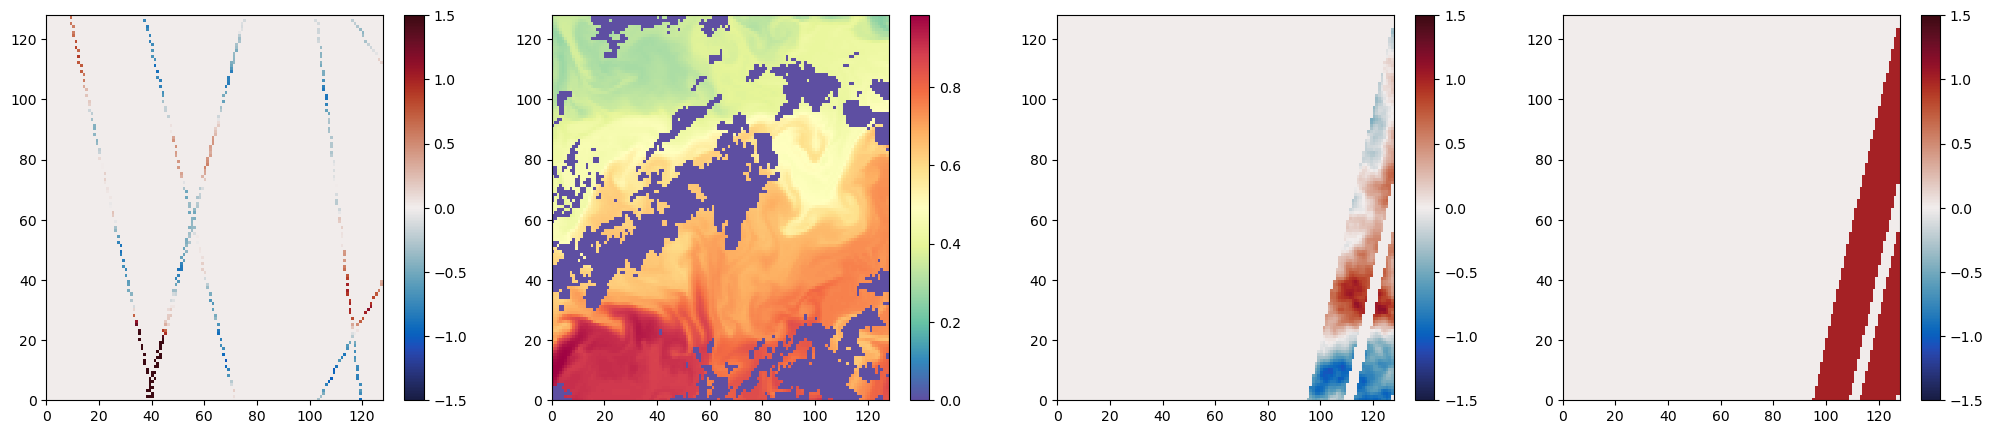

SSH swath std tensor(0.0751, dtype=torch.float32)
SST truth std tensor(0.3276, dtype=torch.float32)
SSH truth std tensor(0.2728)


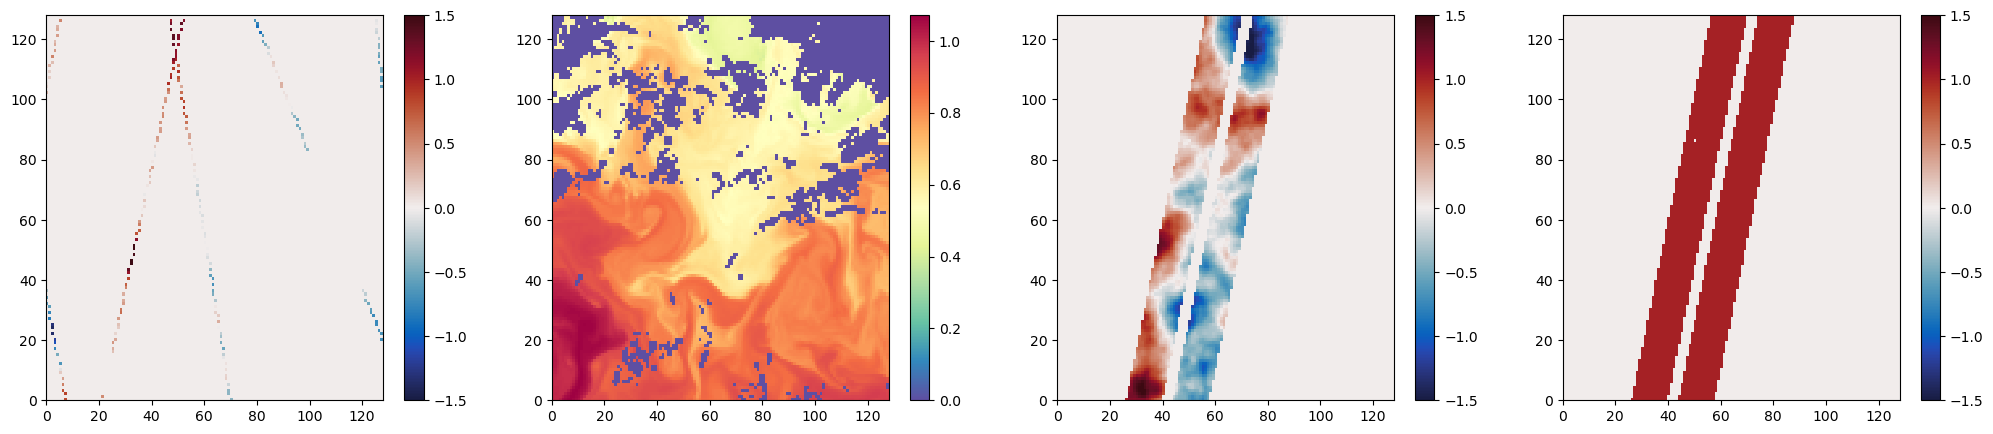

SSH swath std tensor(0.0595, dtype=torch.float32)
SST truth std tensor(0.4805, dtype=torch.float32)
SSH truth std tensor(0.1961)


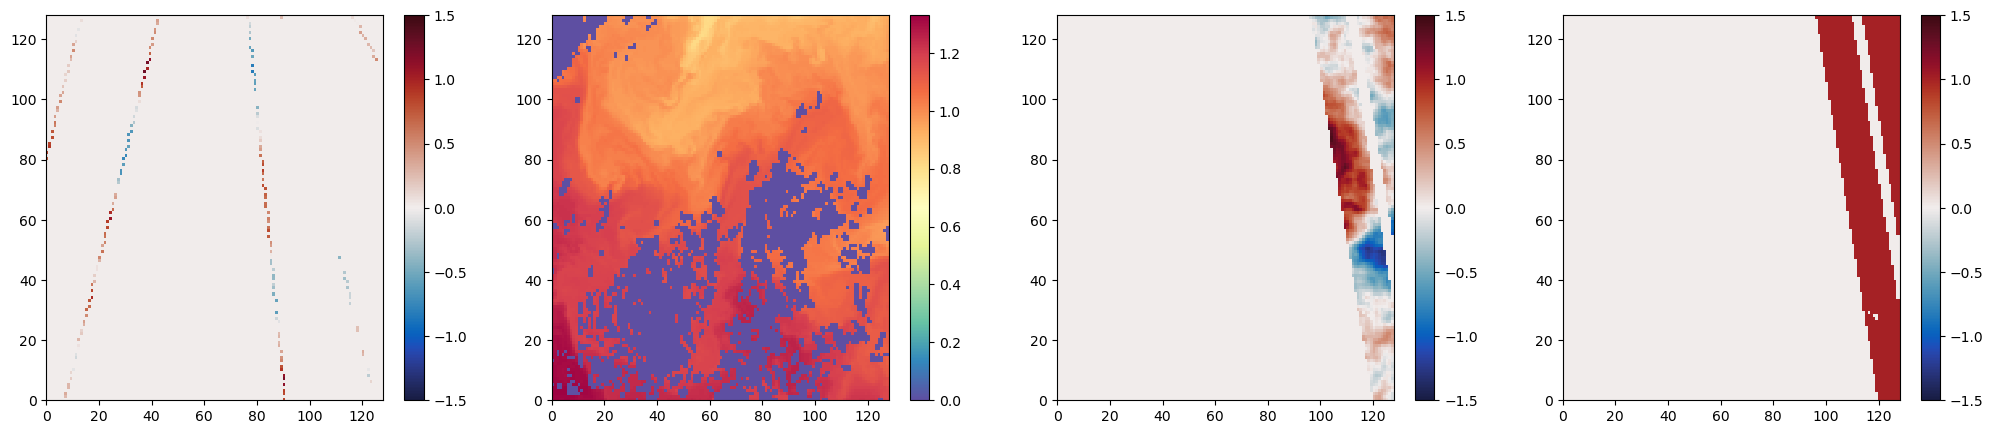

SSH swath std tensor(0.1934, dtype=torch.float32)
SST truth std tensor(0.1103, dtype=torch.float32)
SSH truth std tensor(0.7571)


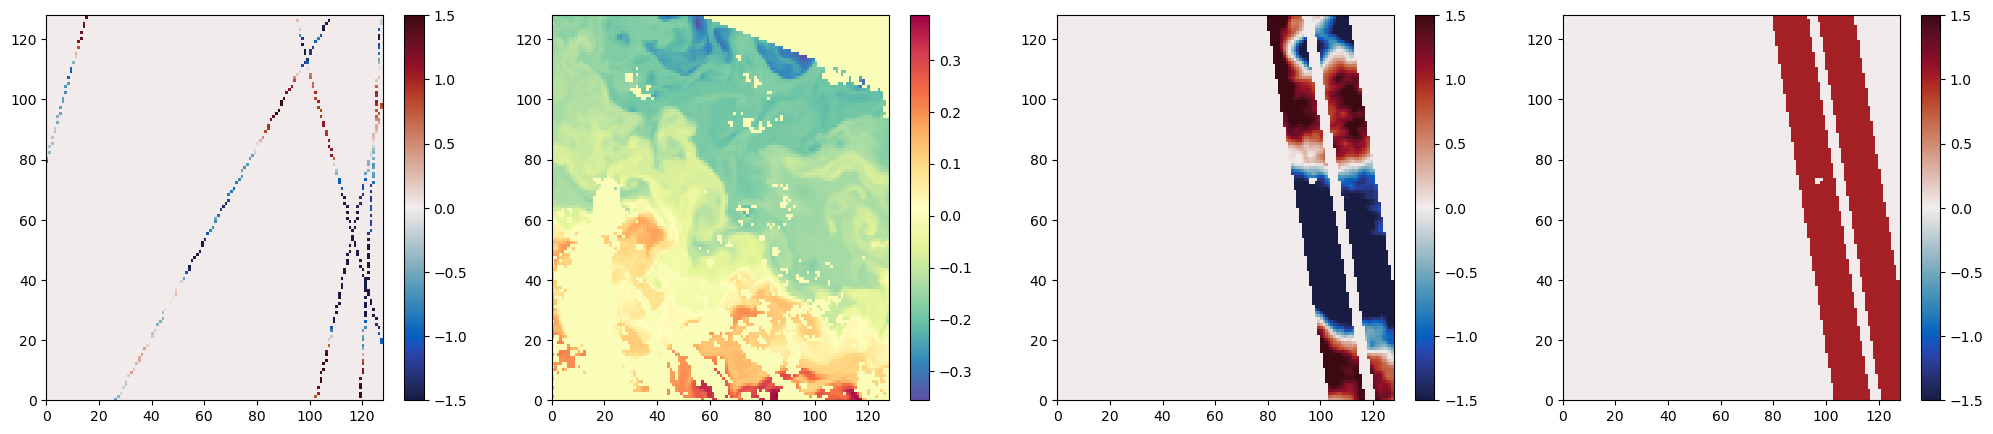

SSH swath std tensor(0.0776, dtype=torch.float32)
SST truth std tensor(0.6802, dtype=torch.float32)
SSH truth std tensor(0.2317)


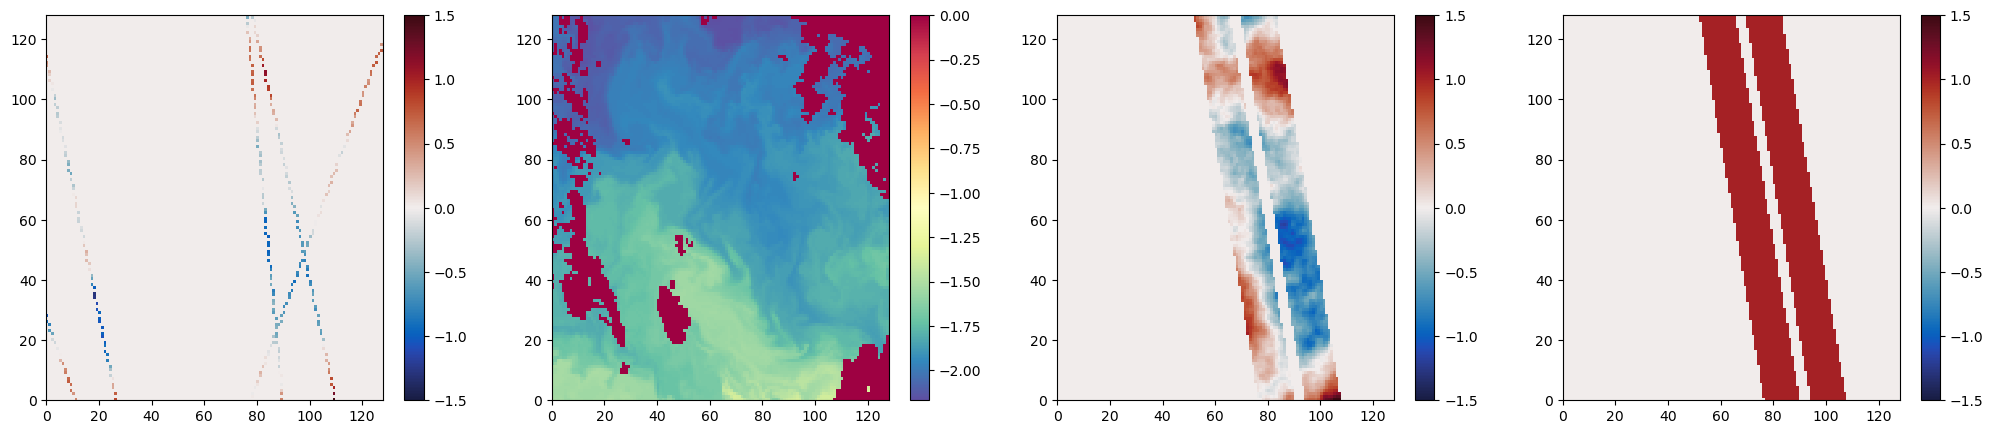

SSH swath std tensor(0.0703, dtype=torch.float32)
SST truth std tensor(0.2255, dtype=torch.float32)
SSH truth std tensor(0.2668)


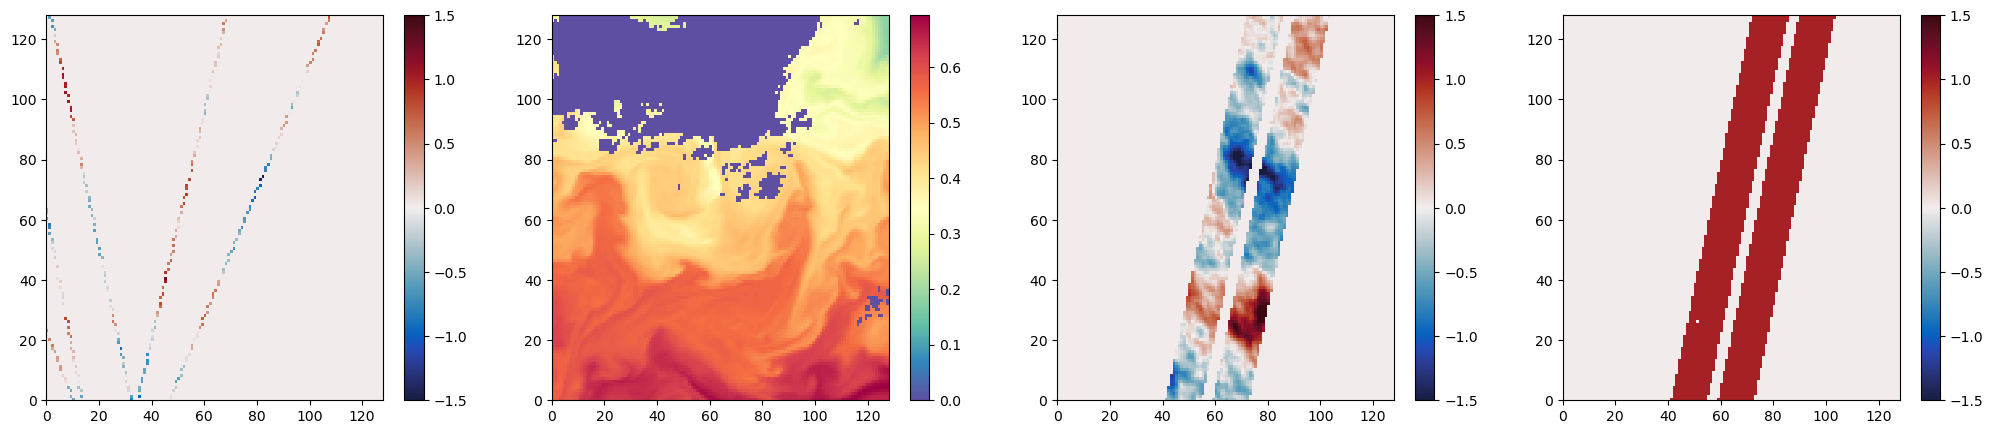

SSH swath std tensor(0.0199, dtype=torch.float32)
SST truth std tensor(0.5012, dtype=torch.float32)
SSH truth std tensor(0.1588)


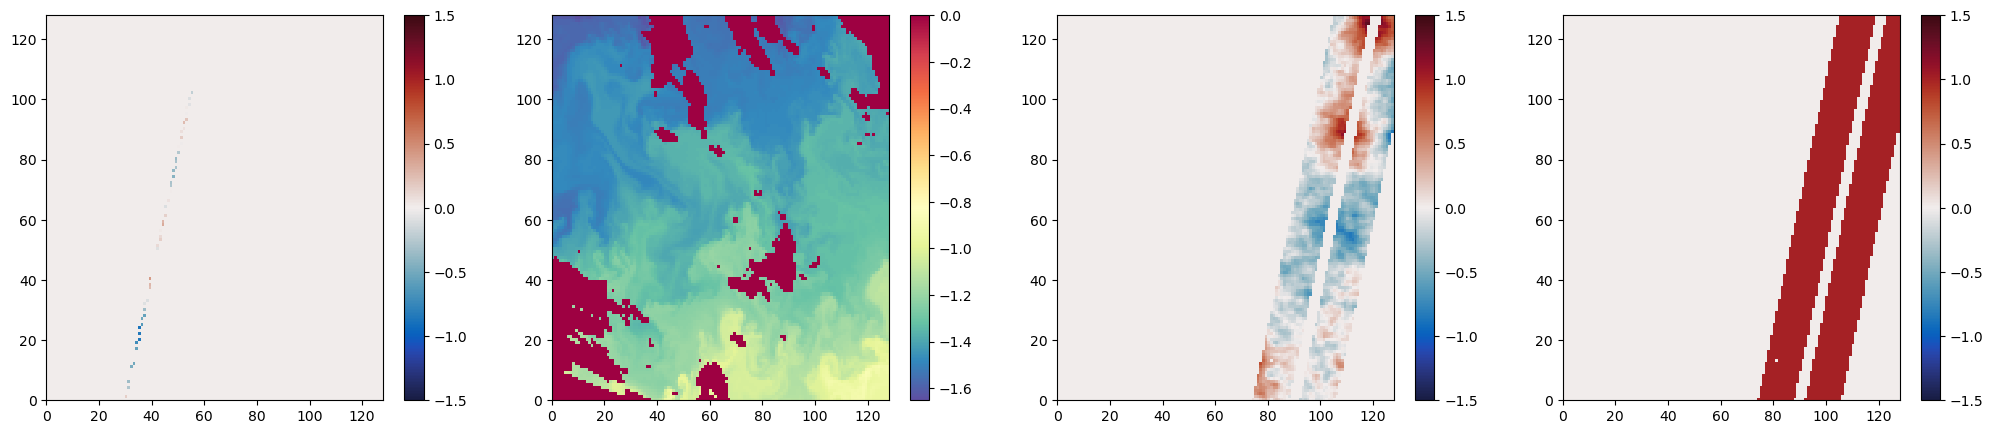

SSH swath std tensor(0.0919, dtype=torch.float32)
SST truth std tensor(0.5980, dtype=torch.float32)
SSH truth std tensor(0.3006)


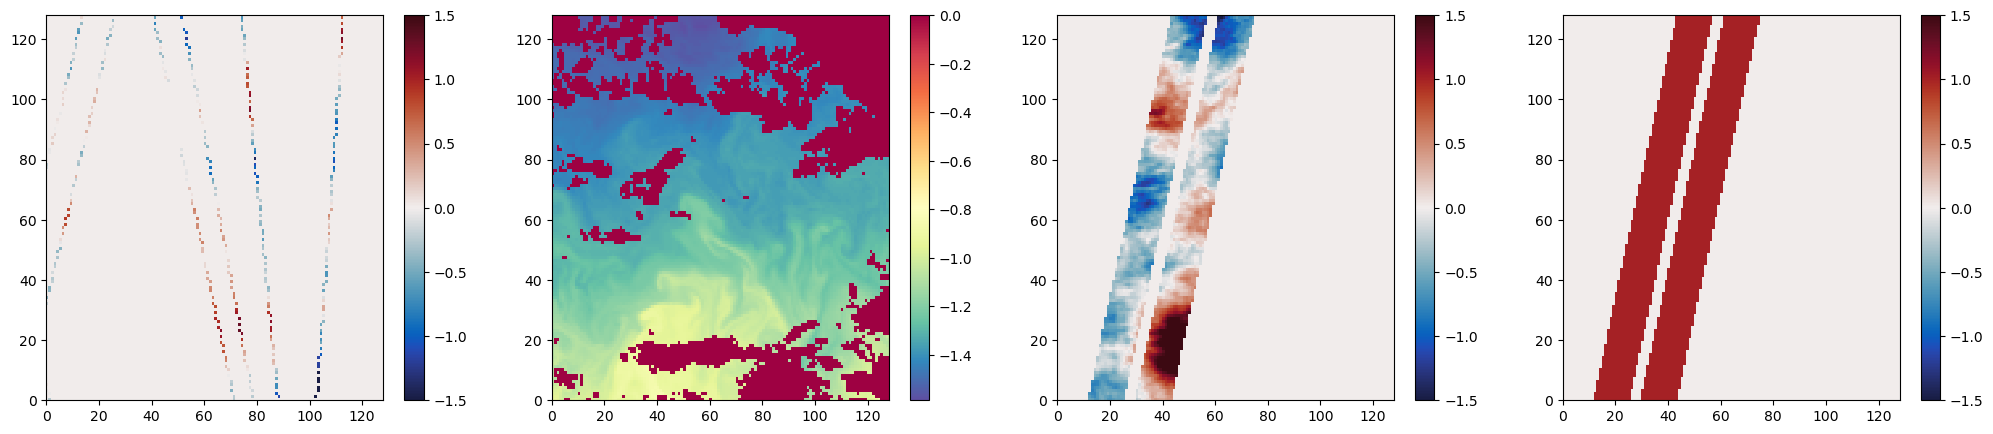

SSH swath std tensor(0.0502, dtype=torch.float32)
SST truth std tensor(0.1728, dtype=torch.float32)
SSH truth std tensor(0.3169)


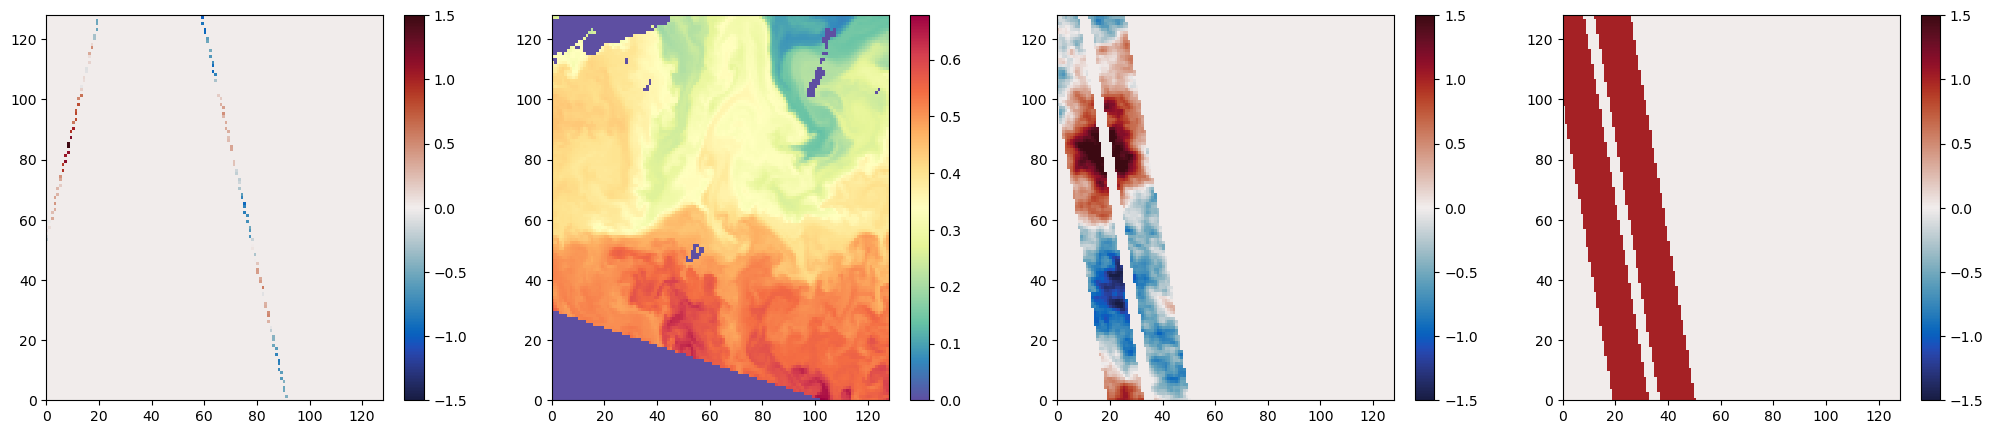

SSH swath std tensor(0.2324, dtype=torch.float32)
SST truth std tensor(0.4954, dtype=torch.float32)
SSH truth std tensor(0.3833)


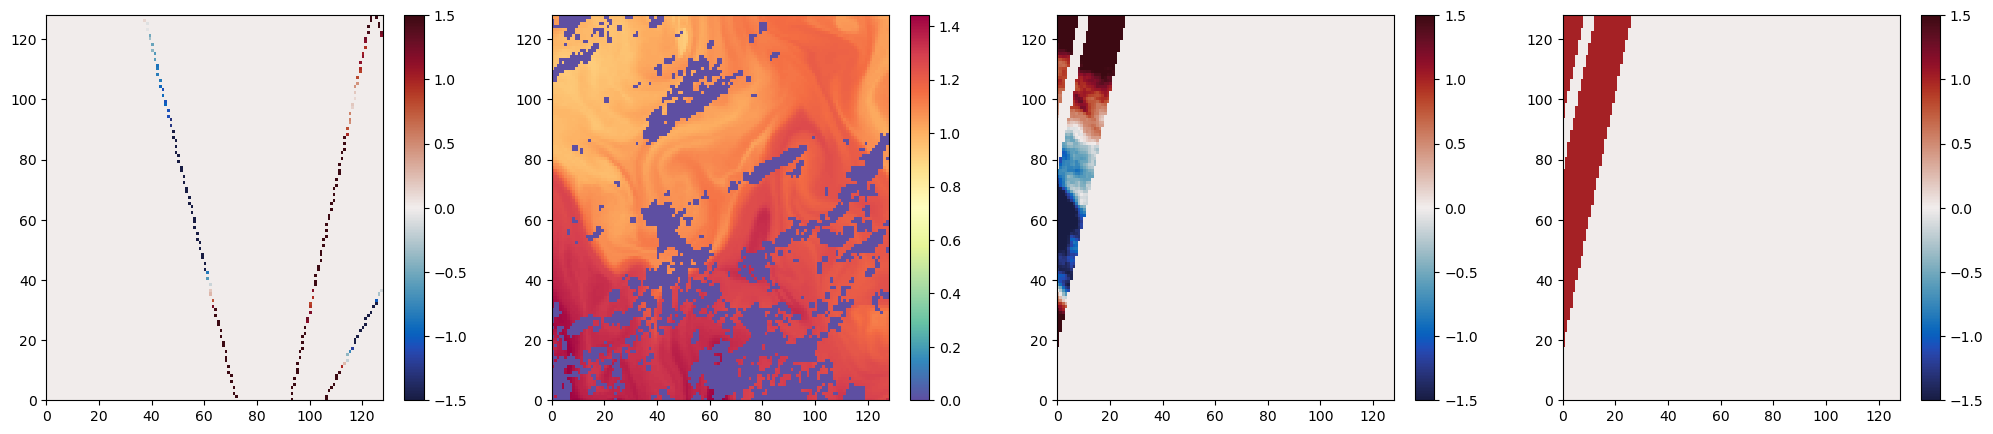

SSH swath std tensor(0.0870, dtype=torch.float32)
SST truth std tensor(0.4923, dtype=torch.float32)
SSH truth std tensor(0.3288)


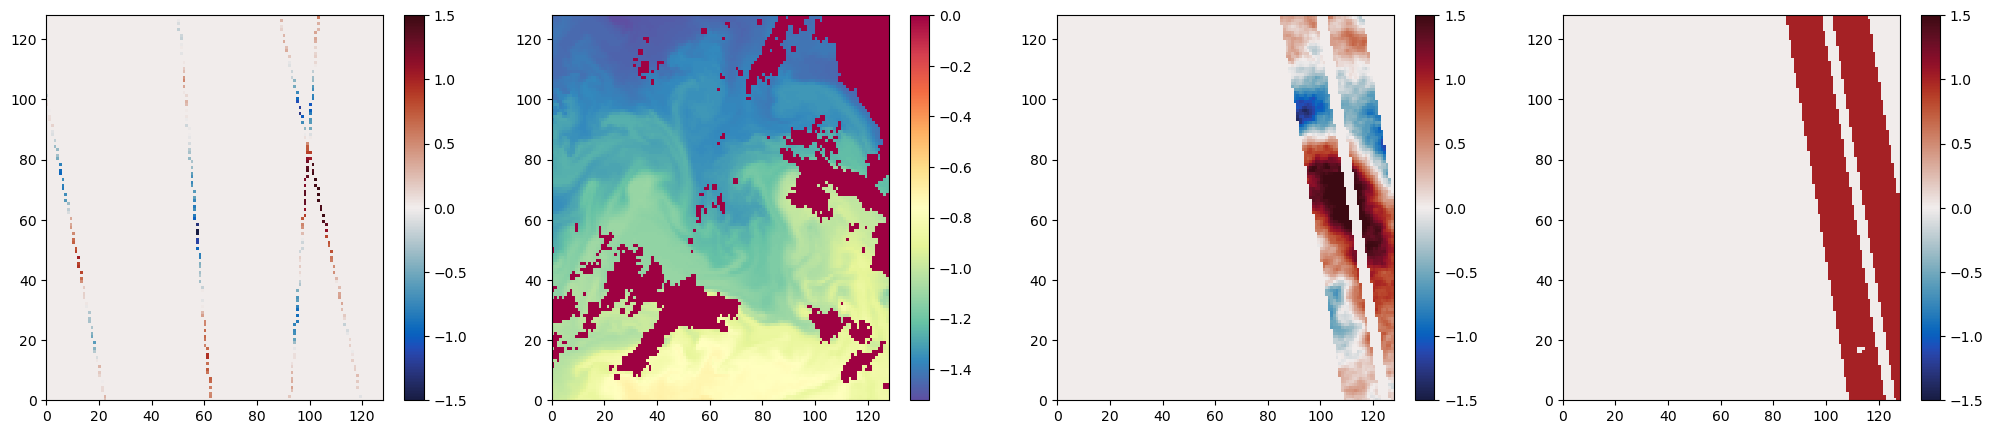

SSH swath std tensor(0.0729, dtype=torch.float32)
SST truth std tensor(0.4111, dtype=torch.float32)
SSH truth std tensor(0.2061)


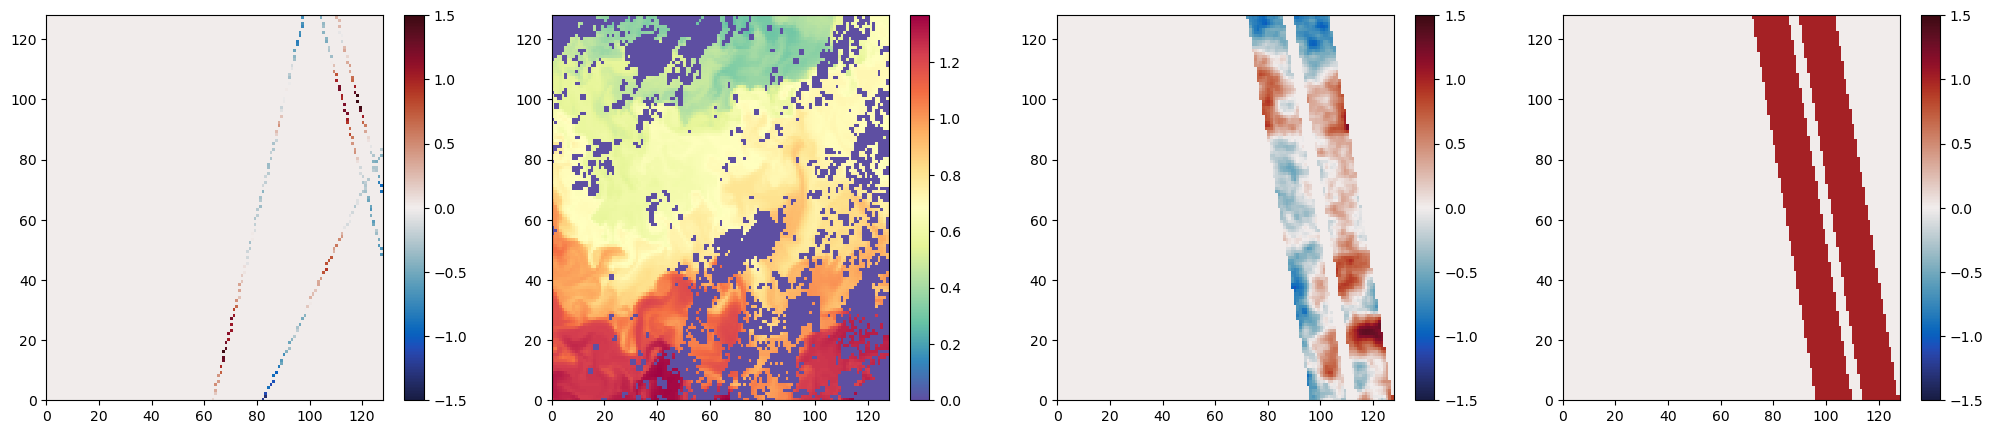

SSH swath std tensor(0., dtype=torch.float32)
SST truth std tensor(0.7946, dtype=torch.float32)
SSH truth std tensor(0.2101)


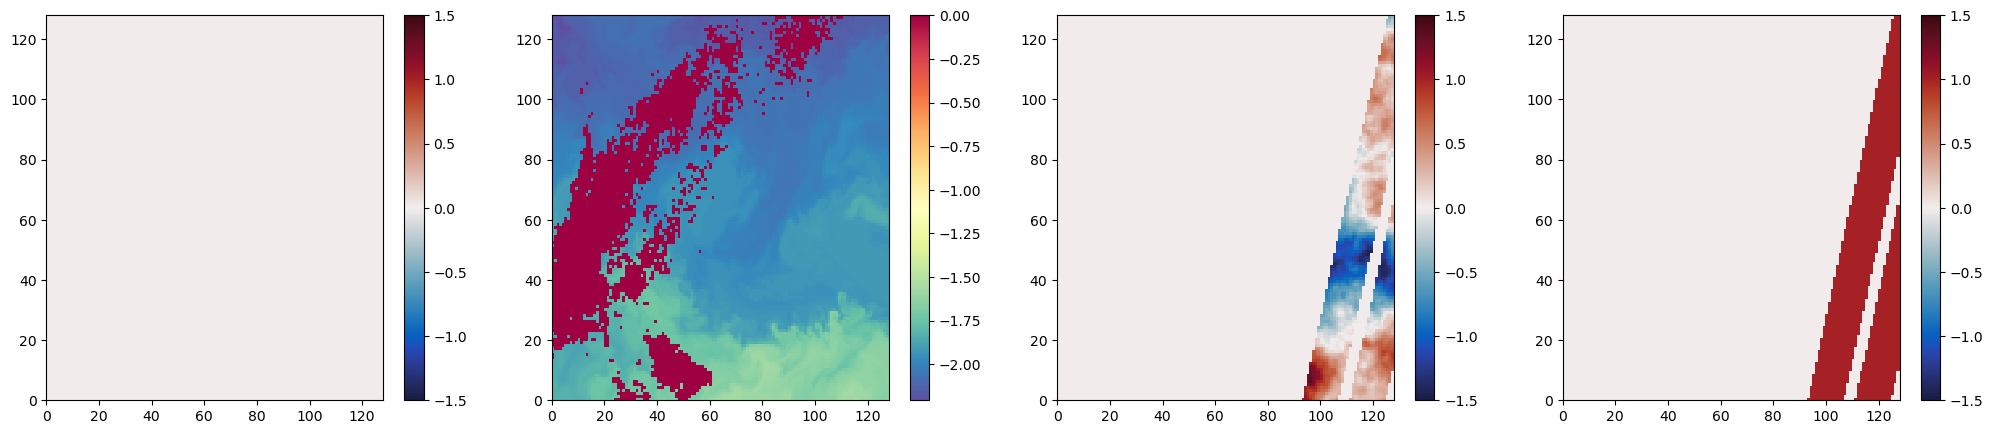

SSH swath std tensor(0.1037, dtype=torch.float32)
SST truth std tensor(0.3871, dtype=torch.float32)
SSH truth std tensor(0.2854)


SSH swath std tensor(0.0824, dtype=torch.float32)
SST truth std tensor(0.4004, dtype=torch.float32)
SSH truth std tensor(0.1191)


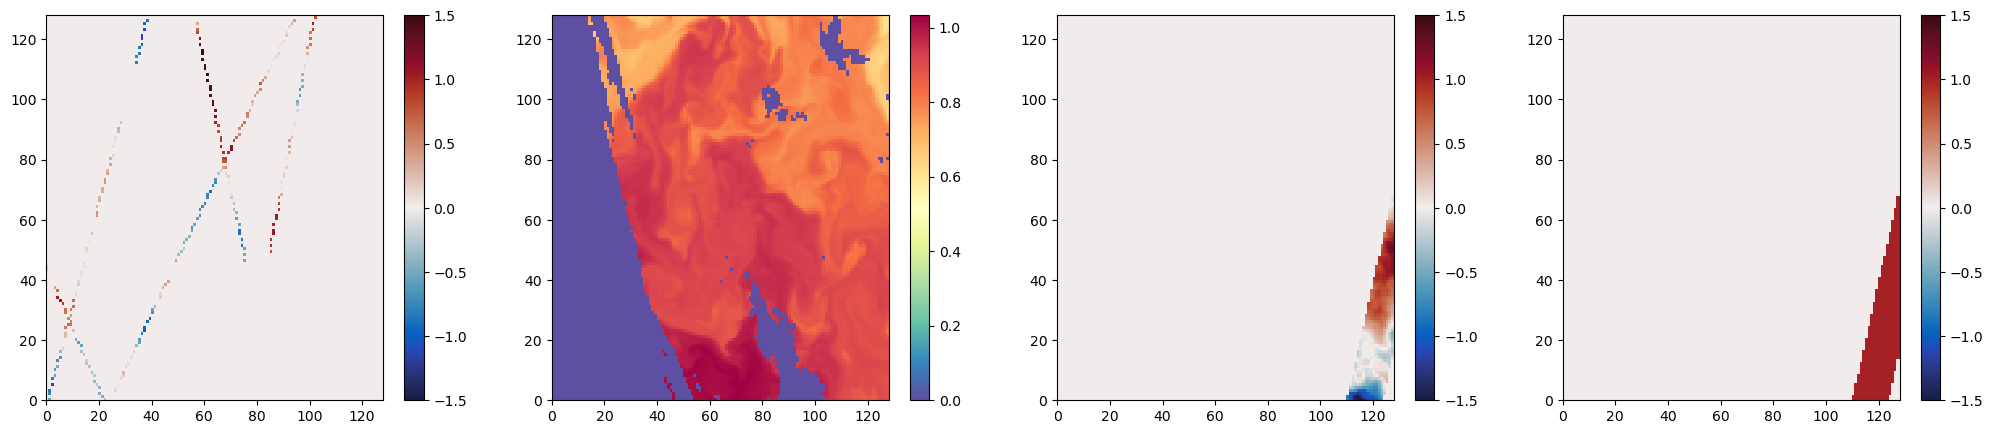

SSH swath std tensor(0.0618, dtype=torch.float32)
SST truth std tensor(0.4505, dtype=torch.float32)
SSH truth std tensor(0.2789)


SSH swath std tensor(0.1078, dtype=torch.float32)
SST truth std tensor(0.5829, dtype=torch.float32)
SSH truth std tensor(0.3379)


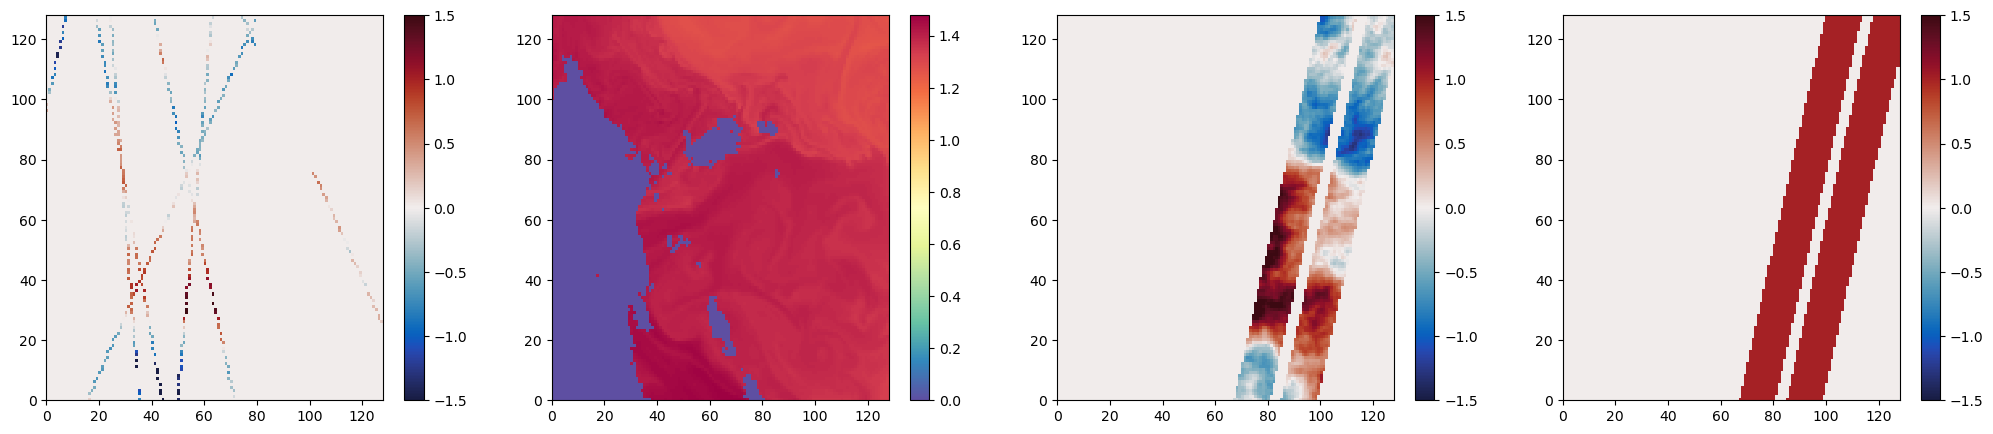

SSH swath std tensor(0.0515, dtype=torch.float32)
SST truth std tensor(0.4608, dtype=torch.float32)
SSH truth std tensor(0.)


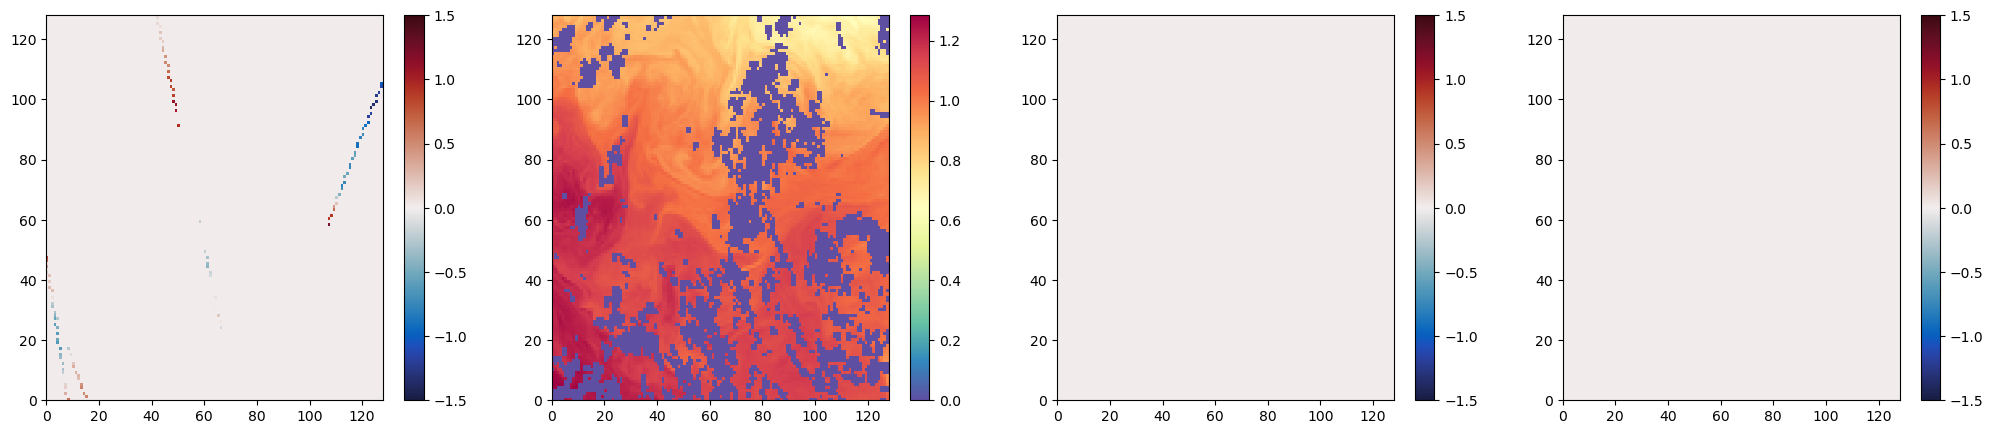

SSH swath std tensor(0.0561, dtype=torch.float32)
SST truth std tensor(0.3069, dtype=torch.float32)
SSH truth std tensor(0.1931)


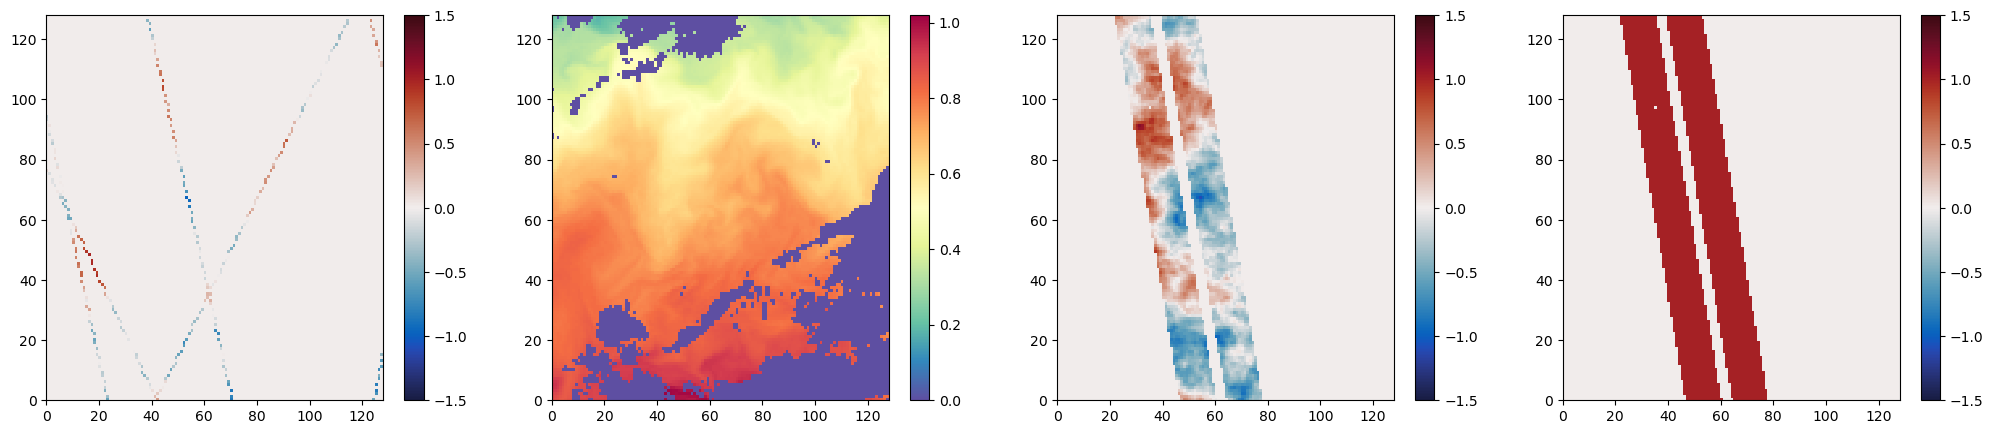

SSH swath std tensor(0.1361, dtype=torch.float32)
SST truth std tensor(0.4038, dtype=torch.float32)
SSH truth std tensor(0.0367)


SSH swath std tensor(0.3244, dtype=torch.float32)
SST truth std tensor(0.5163, dtype=torch.float32)
SSH truth std tensor(0.9708)


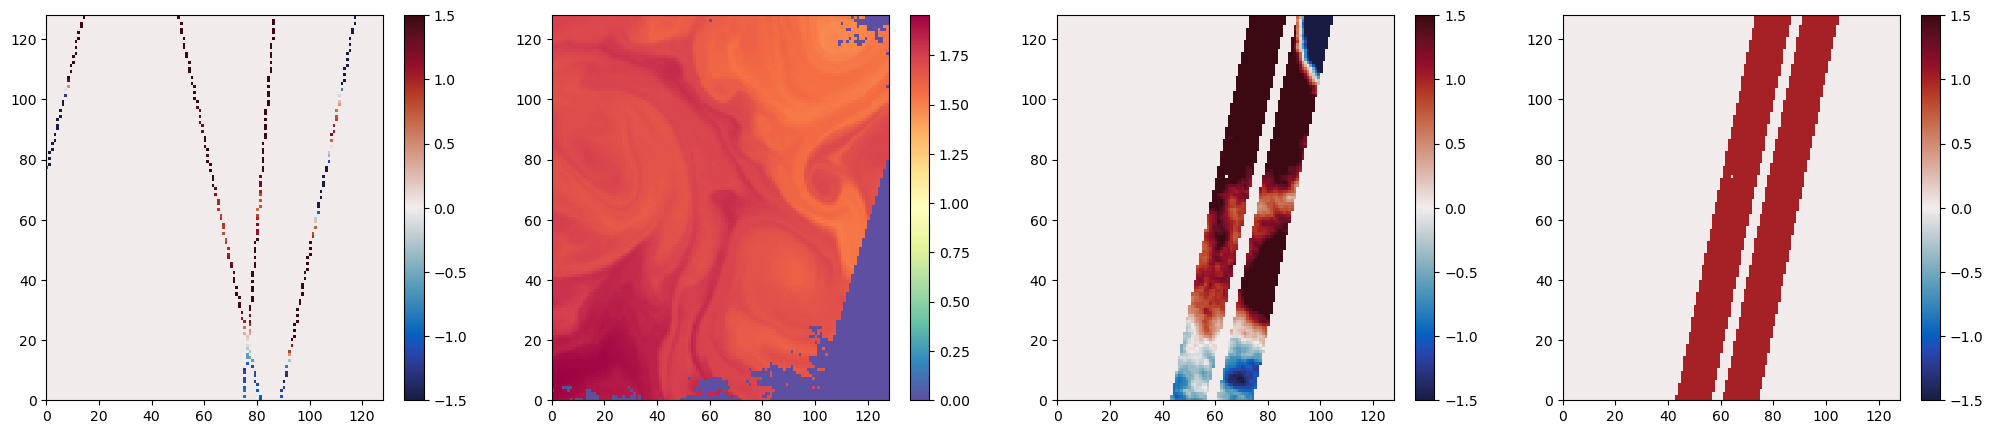

SSH swath std tensor(0.0569, dtype=torch.float32)
SST truth std tensor(0.2071, dtype=torch.float32)
SSH truth std tensor(0.2815)


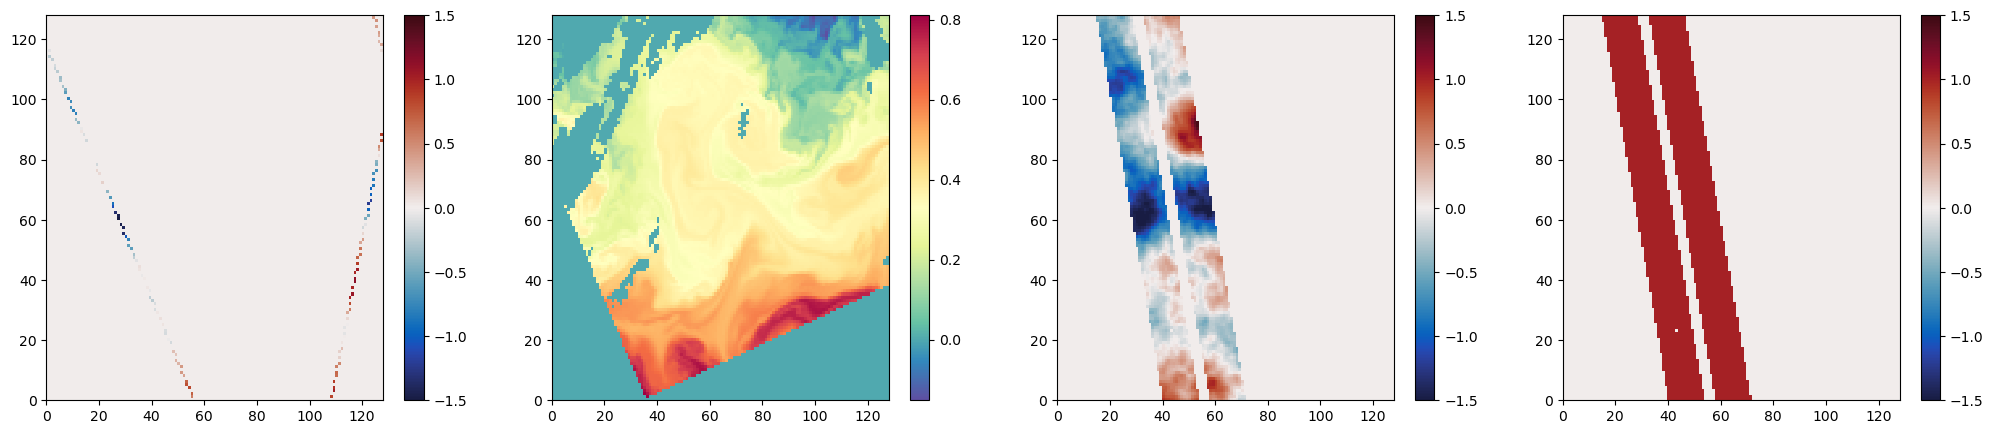

SSH swath std tensor(0.0350, dtype=torch.float32)
SST truth std tensor(0.3663, dtype=torch.float32)
SSH truth std tensor(0.2439)


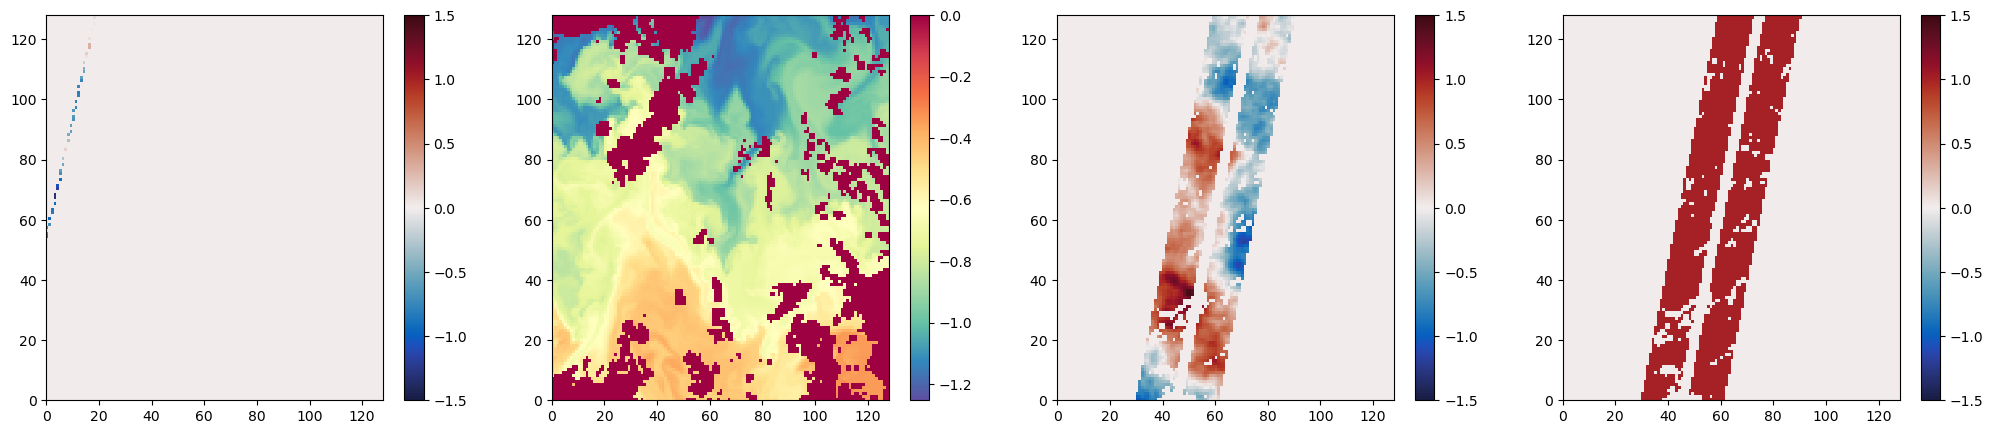

SSH swath std tensor(0.0630, dtype=torch.float32)
SST truth std tensor(0.8493, dtype=torch.float32)
SSH truth std tensor(0.1805)


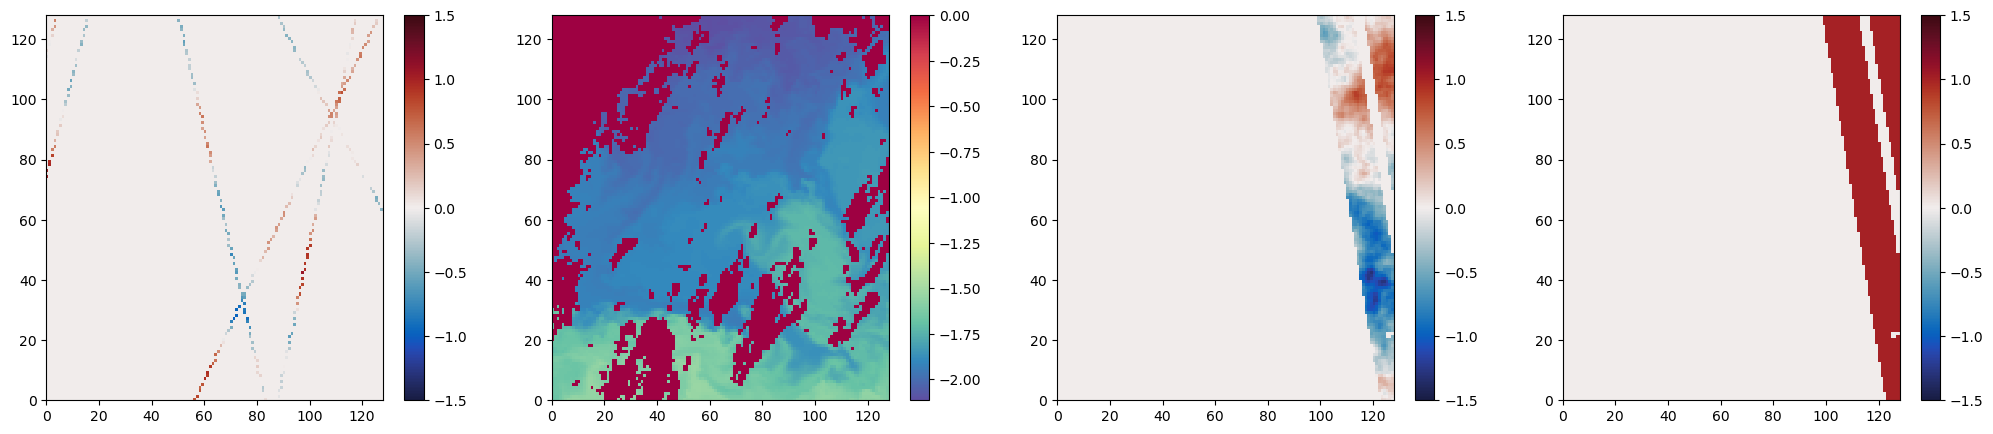

SSH swath std tensor(0.0794, dtype=torch.float32)
SST truth std tensor(0.2962, dtype=torch.float32)
SSH truth std tensor(0.3495)


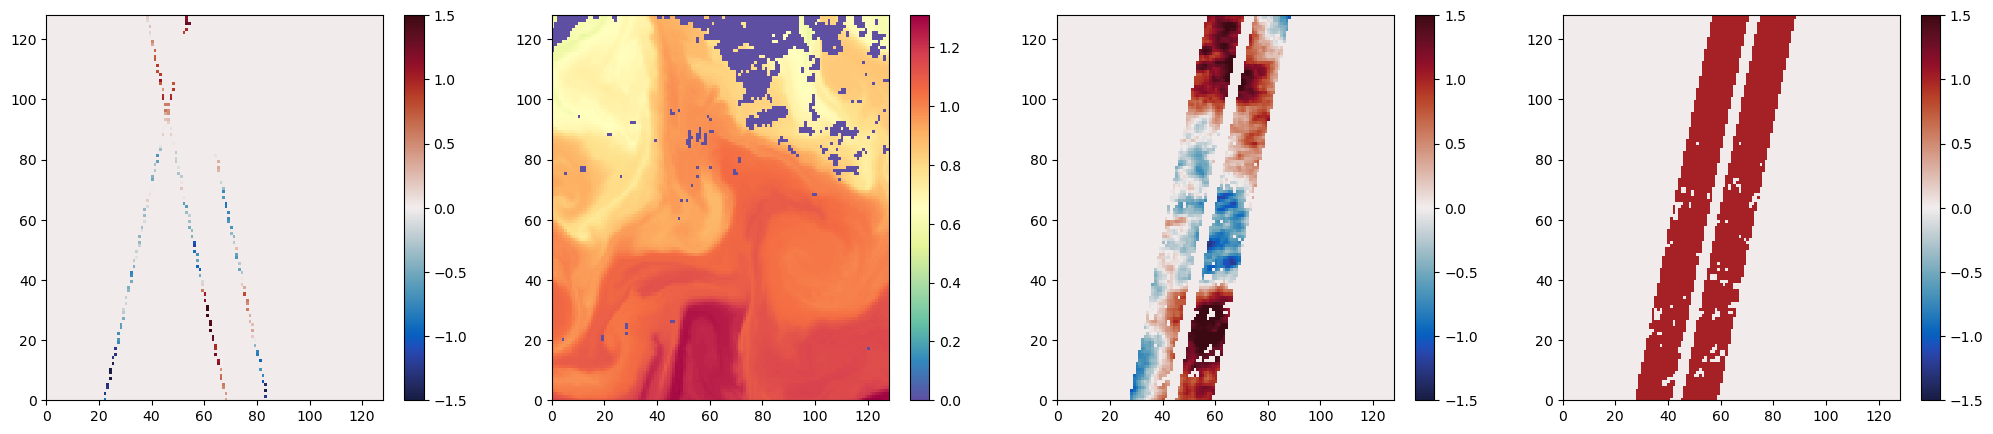

SSH swath std tensor(0.0617, dtype=torch.float32)
SST truth std tensor(0.2714, dtype=torch.float32)
SSH truth std tensor(0.2746)


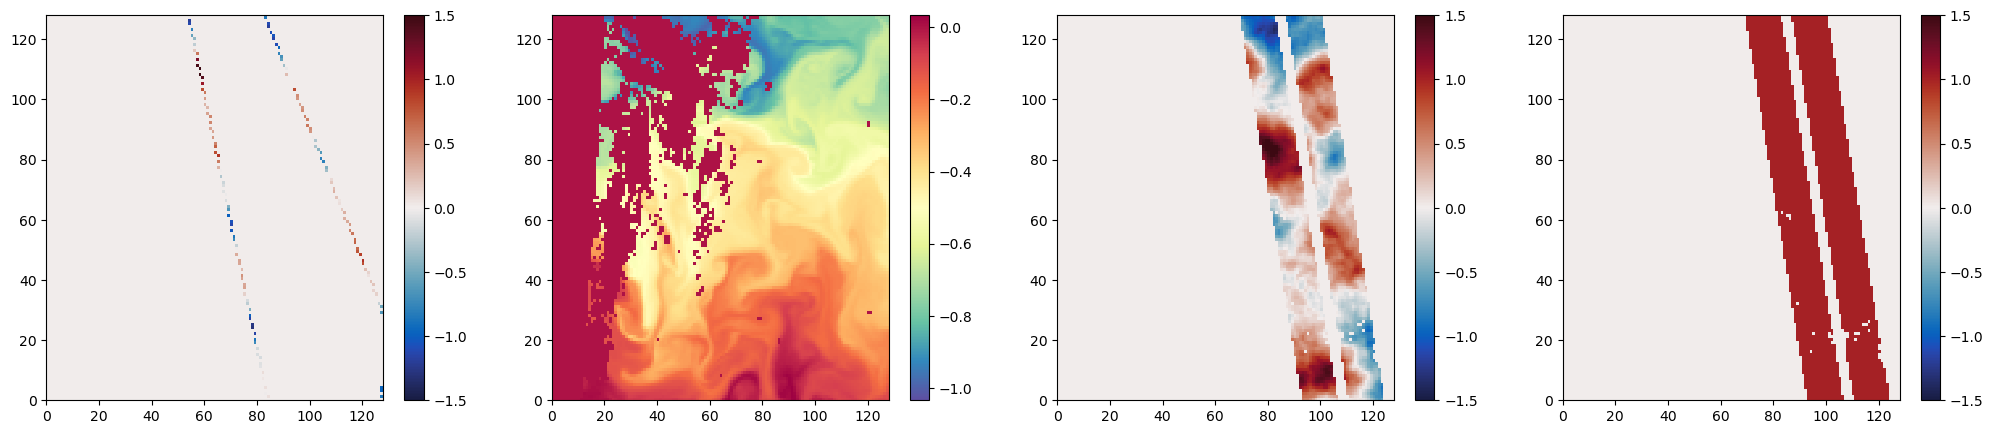

SSH swath std tensor(0.2274, dtype=torch.float32)
SST truth std tensor(0.5029, dtype=torch.float32)
SSH truth std tensor(0.9675)


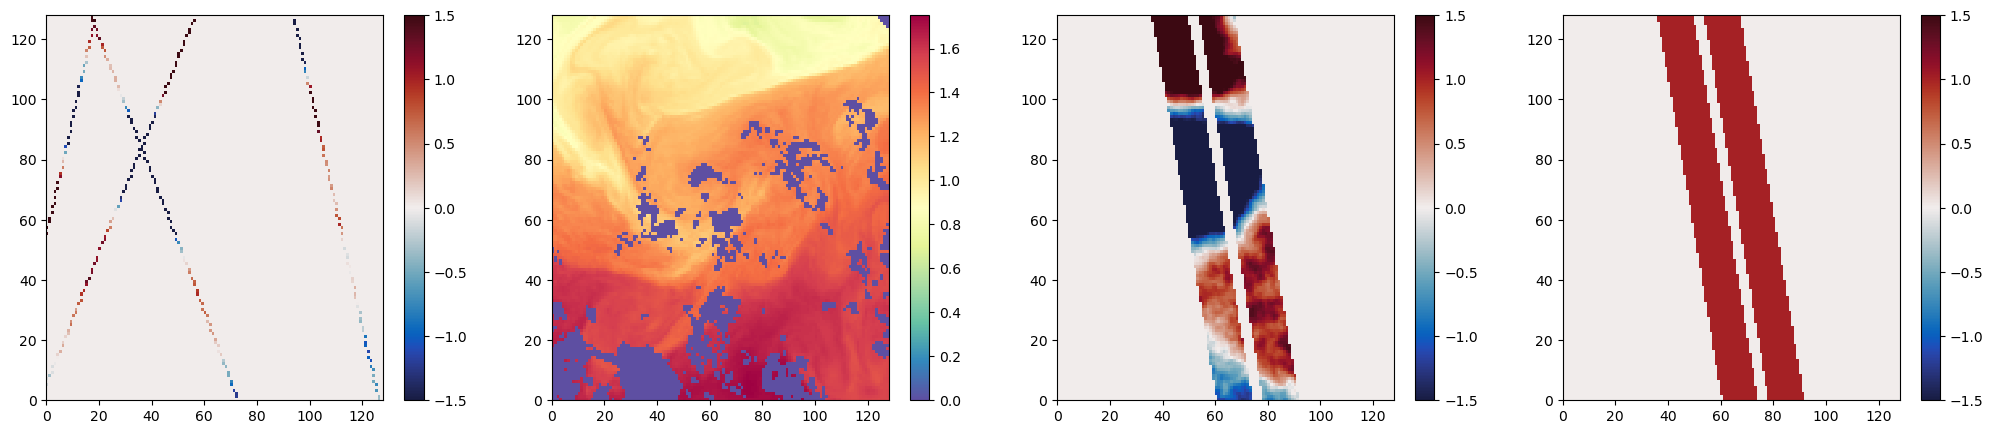

SSH swath std tensor(0.1525, dtype=torch.float32)
SST truth std tensor(0.5806, dtype=torch.float32)
SSH truth std tensor(0.4571)


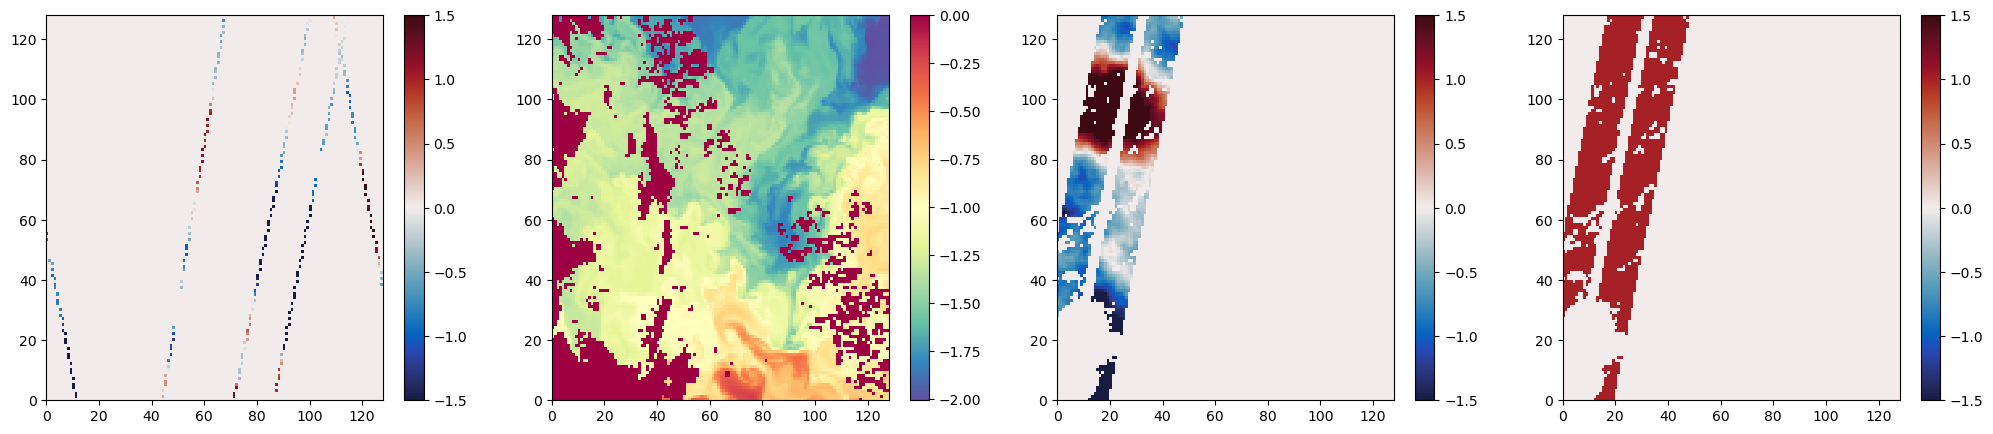

SSH swath std tensor(0.0565, dtype=torch.float32)
SST truth std tensor(0.4071, dtype=torch.float32)
SSH truth std tensor(0.2365)


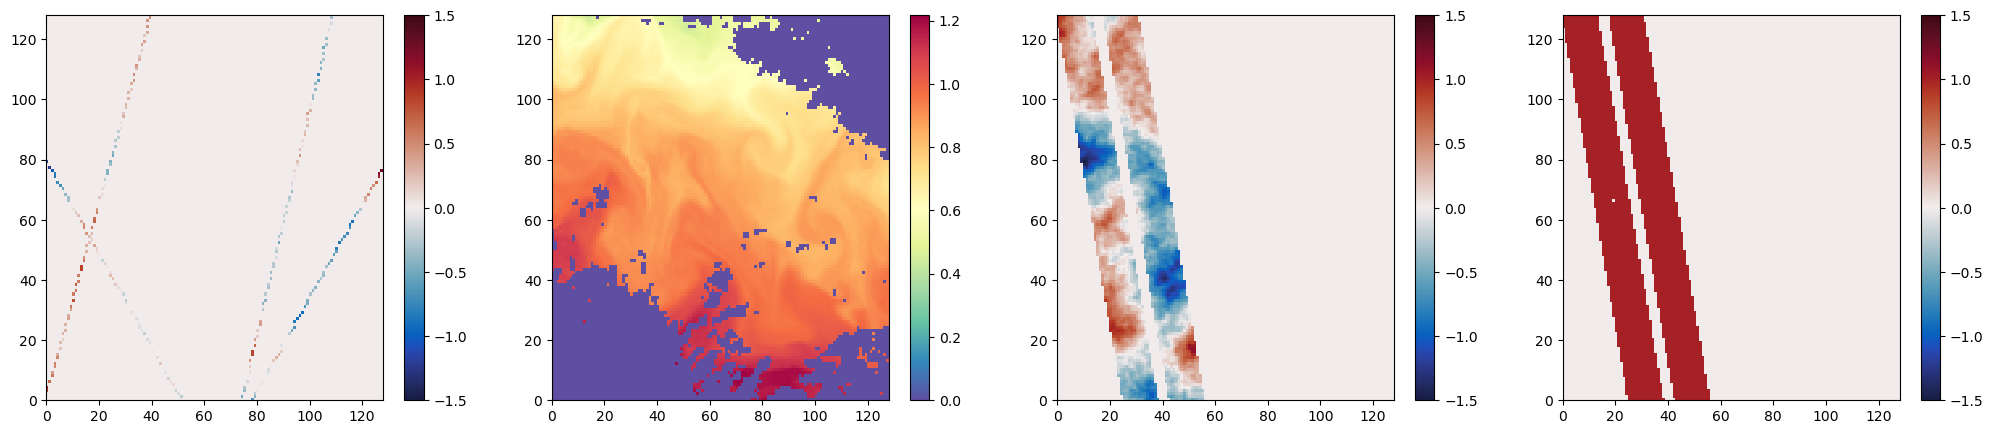

SSH swath std tensor(0.1472, dtype=torch.float32)
SST truth std tensor(0.3327, dtype=torch.float32)
SSH truth std tensor(0.0226)


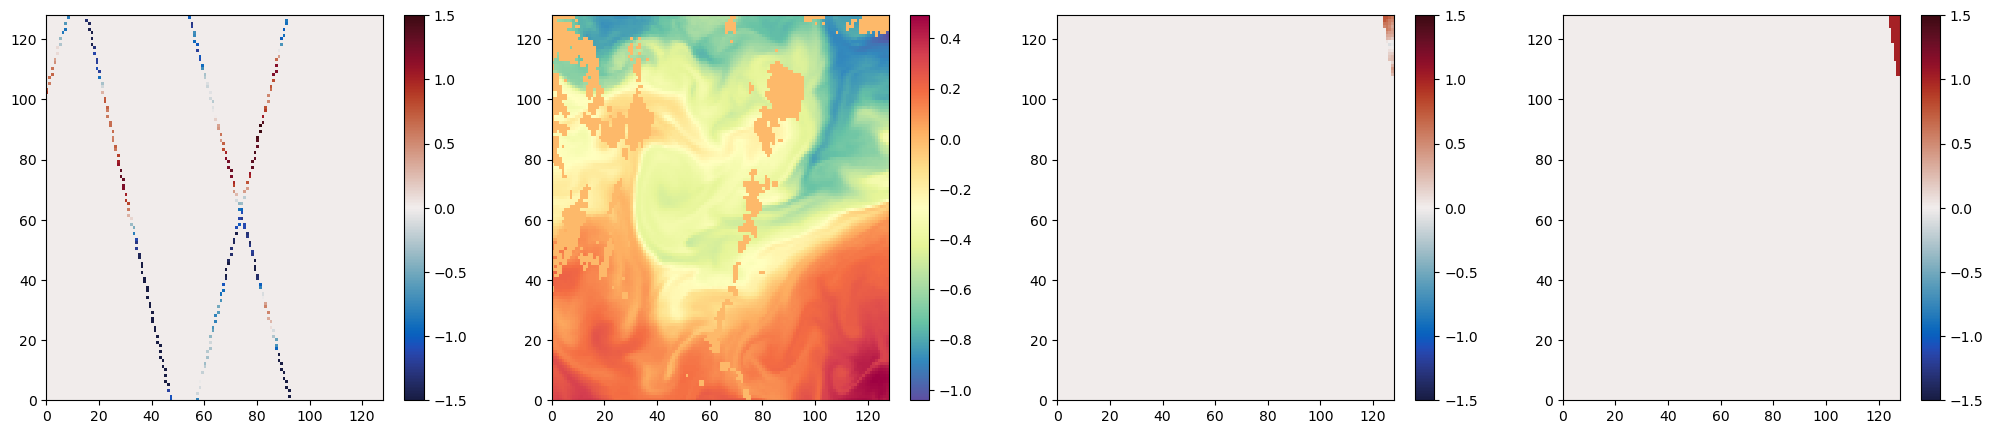

SSH swath std tensor(0.0590, dtype=torch.float32)
SST truth std tensor(0.1512, dtype=torch.float32)
SSH truth std tensor(0.2333)


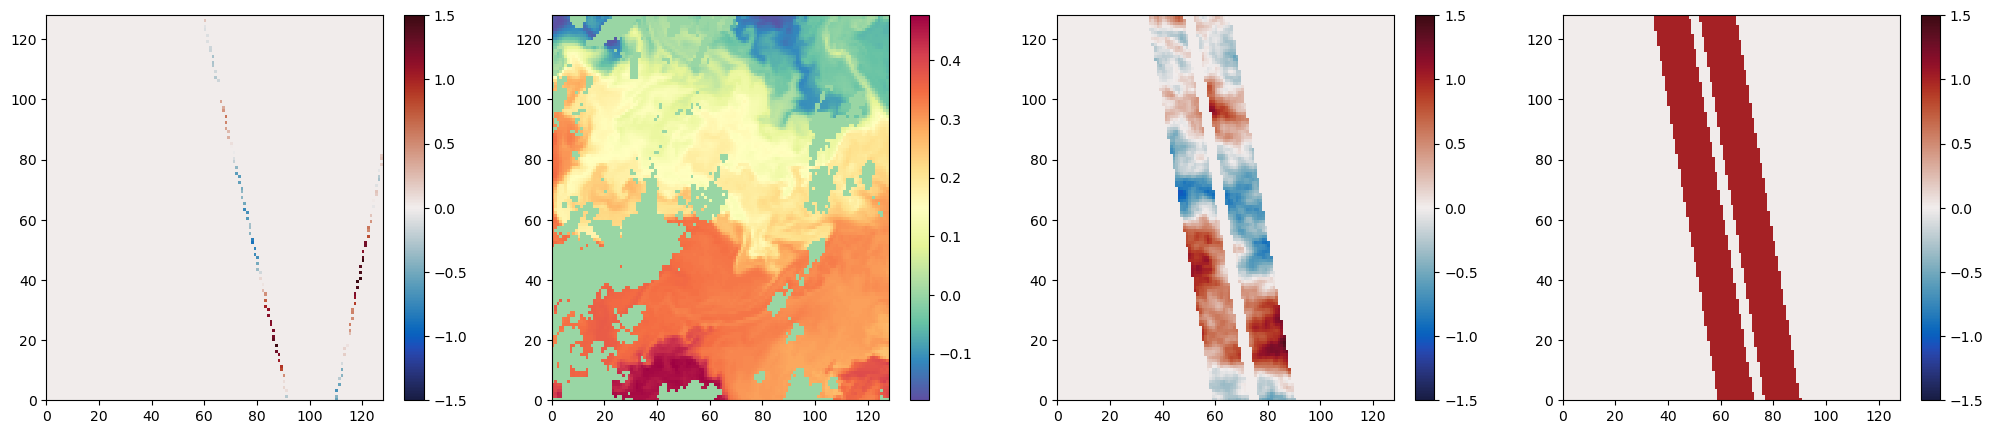

SSH swath std tensor(0.1180, dtype=torch.float32)
SST truth std tensor(0.4262, dtype=torch.float32)
SSH truth std tensor(0.3423)


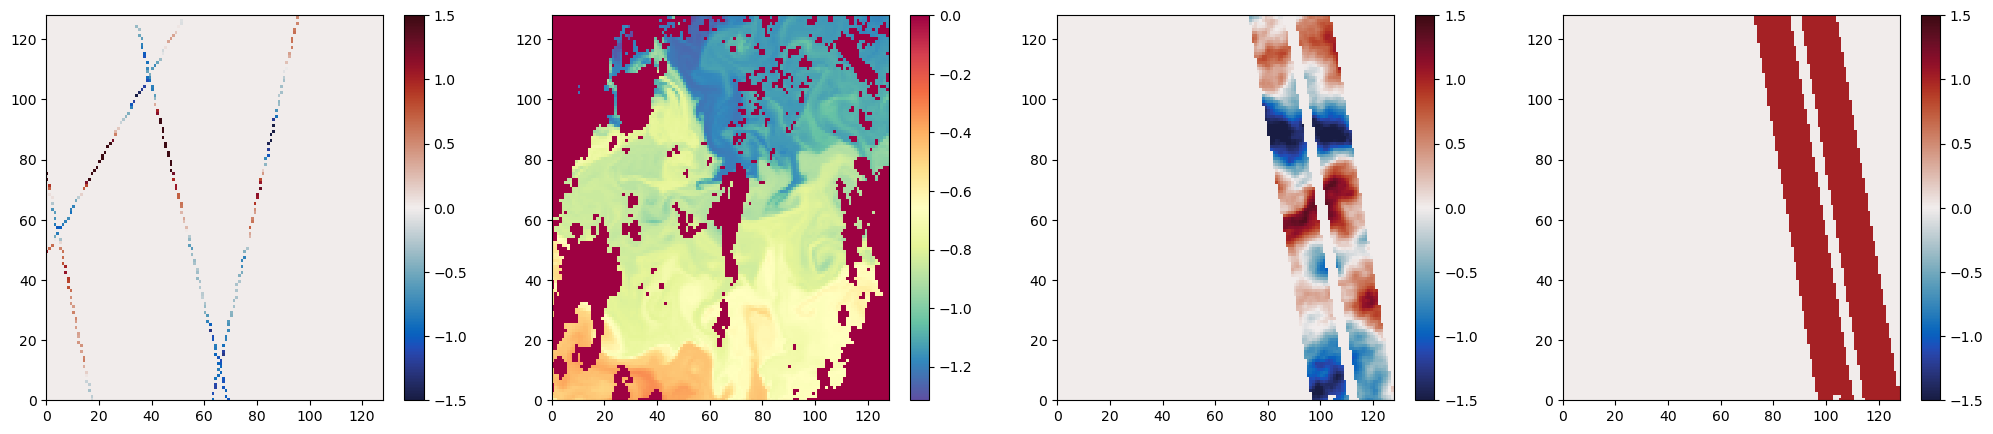

In [91]:
ssh_vminmax = 1.5
N_t = cfg.data["N_t"]

for i in range(len(x)):
    fig, axs = plt.subplots(1,4,figsize=(25,5))
    print("SSH swath std",torch.std(x[i,int(N_t/2),0,:,:]))
    print("SST truth std",torch.std(x[i,int(N_t/2),1,:,:]))
    print("SSH truth std",torch.std(y[i,int(N_t/2),0,:,:]))
    ims = [axs[0].pcolor(x[i,int(N_t/2),0,:,:],cmap=cm.cm.balance,vmin=-ssh_vminmax,vmax=ssh_vminmax),
           #axs[1].pcolor(np.where(x[i,int(N_t/2),1,:,:]==0,np.nan,x[i,int(N_t/2),1,:,:]),cmap="Spectral_r"),
           axs[1].pcolor(x[i,int(N_t/2),1,:,:],cmap="Spectral_r"),
           axs[2].pcolor(y[i,int(N_t/2),0,:,:],cmap=cm.cm.balance,vmin=-ssh_vminmax,vmax=ssh_vminmax),
           axs[3].pcolor(y[i,int(N_t/2),0,:,:]!=0,cmap=cm.cm.balance,vmin=-ssh_vminmax,vmax=ssh_vminmax),
           ]
    for i, im in enumerate(ims):
        fig.colorbar(im,ax=axs[i])
    plt.show()
    plt.close()
    

# Model dry run

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import base_simvip_template
import simvip_model
base_simvip_template = reload(base_simvip_template)
data_loaders = reload(data_loaders)

# 1. Create batch of the dataset
x, y, = next(iter(train_data_loader))
x, y = x.to(device).double(), y.to(device).double()
B, T, C, H, W = y.shape  # small dimensions
print("y.shape")
print(B, T, C, H, W)

# 2. Instantiate a minimal SimVP model (or stub one)
model = simvip_model.SimVP_Model_no_skip_sst(
    in_shape=(T, C, H, W),
    # pass other required cfg values; using dummy values below
    hidden_dim=16, depth=1, kernel_size=3,
    num_layers=1, num_hidden_layers=1,
    lr=1e-3, alpha0=1.0, alpha1=0.1, alpha2=0.1,
    masked_loss=False
)
#device = torch.device('cpu')
model = model.to(device)
model_dtype = next(model.parameters()).dtype
model_device = next(model.parameters()).device
x = x.to(device=model_device, dtype=model_dtype)
y = y.to(device=model_device, dtype=model_dtype)

# 3. Instantiate filters
filters = base_simvip_template.GradientFilters(C,model_device,model_dtype)
loss = base_simvip_template.compute_loss(model, x, y, 'train', 1.0, 0.1, 0.1, filters, masked_loss=True)
print("Single-batch LOSS:", loss.item())

# 5. Mini-train loop invocation
print("Running mini-training loop on local machine...")
trained_model = base_simvip_template.train_model(
    model=model,
    device=device,
    model_name="dryrun",
    train_loader=train_data_loader,
    val_loader=val_data_loader,
    test_loader=val_data_loader,
    num_epochs=1,
    lr=1e-3,
    alpha0=1.0, alpha1=0.1, alpha2=0.1,
    masked_loss=False,
    checkpoint_dir="tmp_ckpt",
    wandb_config=None,
    hydra_cfg=type('C', (), {'training': {'enable_profiler': True}})(),
    dry_run=True,
)
print("✅ Dry run complete!")

In [142]:
import torch
import torch.nn as nn
import numpy as np
import base_simvip_template
import simvip_model
base_simvip_template = reload(base_simvip_template)
data_loaders = reload(data_loaders)

# 1. Create batch of the dataset
x, y, = next(iter(train_data_loader))
x, y = x.to(device).double(), y.to(device).double()
B, T, C, H, W = y.shape  # small dimensions
print("y.shape")
print(B, T, C, H, W)

# 2. Instantiate a minimal SimVP model (or stub one)
model = simvip_model.SimVP_Model_no_skip_sst(
    in_shape=(T, C, H, W),
    # pass other required cfg values; using dummy values below
    hidden_dim=16, depth=1, kernel_size=3,
    num_layers=1, num_hidden_layers=1,
    lr=1e-3, alpha0=1.0, alpha1=0.1, alpha2=0.1,
    masked_loss=False
)
#device = torch.device('cpu')
model = model.to(device)
model_dtype = next(model.parameters()).dtype
model_device = next(model.parameters()).device
x = x.to(device=model_device, dtype=model_dtype)
y = y.to(device=model_device, dtype=model_dtype)

# 3. Instantiate filters
filters = base_simvip_template.GradientFilters(C,model_device,model_dtype)
loss = base_simvip_template.compute_loss(model, x, y, 'train', 1.0, 0.1, 0.1, filters, masked_loss=True)
print("Single-batch LOSS:", loss.item())

# 5. Mini-train loop invocation
print("Running mini-training loop on local machine...")
trained_model = base_simvip_template.train_model(
    model=model,
    device=device,
    model_name="dryrun",
    train_loader=train_data_loader,
    val_loader=val_data_loader,
    test_loader=val_data_loader,
    num_epochs=1,
    lr=1e-3,
    alpha0=1.0, alpha1=0.1, alpha2=0.1,
    masked_loss=False,
    checkpoint_dir="tmp_ckpt",
    wandb_config=None,
    hydra_cfg=type('C', (), {'training': {'enable_profiler': True}})(),
    dry_run=True,
)
print("✅ Dry run complete!")

y.shape
20 10 1 128 128
Single-batch LOSS: 2.188045457604763
Running mini-training loop on CPU...
Running detailed dry-run for profiling...
Dataloader time: 33.32059860229492
GPU time: 40.07453489303589
Running detailed dry-run for profiling...
Dataloader time: 33.375128507614136
GPU time: 3.3491785526275635
Running detailed dry-run for profiling...
Dataloader time: 33.77960157394409
GPU time: 3.329771041870117
Running detailed dry-run for profiling...
Dataloader time: 33.46333718299866
GPU time: 3.3442890644073486
Running detailed dry-run for profiling...
Dataloader time: 33.64037489891052
GPU time: 3.3564302921295166
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU ti

In [ ]:
device

In [198]:
aggregate_dir = f"/home/tm3076/scratch/pytorch_learning_tiles/HRS_SST_tiles/"


coords = zarr.load(f"{aggregate_dir}/x_y_coordinates_noland.zarr")


In [201]:
coords[:,2]

array([  0.,   1.,   2.,   3.,   4.,   5.,  12.,  13.,  14.,  15.,  16.,
        17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,  28.,
        29.,  30.,  31.,  32.,  33.,  37.,  38.,  39.,  40.,  41.,  42.,
        43.,  44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,
        54.,  56.,  57.,  58.,  59.,  60.,  61.,  64.,  65.,  66.,  67.,
        68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.,
        79.,  80.,  81.,  84.,  85.,  86.,  87.,  88.,  89.,  92.,  93.,
        94.,  95.,  96.,  97.,  98.,  99., 100., 101., 102., 103., 104.,
       105., 106., 107., 108., 111., 112., 113., 114., 115., 116., 119.,
       120., 121., 122., 123., 124., 125., 126., 127., 128., 129., 130.,
       131., 132., 133., 134., 135., 137., 138., 139., 140., 141., 142.,
       145., 146., 147., 148., 149., 150., 151., 152., 153., 154., 155.,
       156., 157., 158., 159., 160., 161., 163., 164., 165., 166., 167.,
       168., 171., 172., 173., 174., 175., 176., 17

In [ ]:
filters = None
if not filters:
    print(False)
if filters:
    print(True)

In [27]:
x.shape

torch.Size([5, 10, 2, 128, 128])

In [28]:
y_test = y

In [29]:
y_test.shape

torch.Size([5, 10, 1, 128, 128])

In [30]:
y_test[...,1:,1:].shape

torch.Size([5, 10, 1, 127, 127])

In [31]:
y2d = y.permute(0, 2, 1, 3, 4).reshape(B*T, C, H, W).float()
x2d = x.permute(0, 2, 1, 3, 4).reshape(B*T, 2, H, W).float()

y2d_nopermute = y.reshape(B*T, C, H, W).float()
x2d_nopermute = x.reshape(B*T, 2, H, W).float()

In [32]:
B, T, C, H, W = 2, 3, 2, 4, 4
y = torch.zeros(B * T * C * H * W).reshape(B, T, C, H, W)
y[:,:,0,:,:] = 0
y[:,:,1,:,:] = 1
y[:,1,1,:,:] = 2
y[:,2,1,:,:] = 3

y[1,:,0,:,:] = 4
y[1,:,1,:,:] = 5
y[1,1,1,:,:] = 6
y[1,2,1,:,:] = 7

y2d_wrong = y.reshape(B*T, C, H, W)
print(y2d_wrong.shape)  # ✅ shape = [6, 2, 4, 4] — but is it correct?
y2d = y.permute(0, 2, 1, 3, 4)  # [B, C, T, H, W]
y2d = y2d.reshape(B*T, C, H, W)
y2d_nopermute = y.reshape(B*T, C, H, W)


y2d_nopermute[3]

torch.Size([6, 2, 4, 4])


tensor([[[4., 4., 4., 4.],
         [4., 4., 4., 4.],
         [4., 4., 4., 4.],
         [4., 4., 4., 4.]],

        [[5., 5., 5., 5.],
         [5., 5., 5., 5.],
         [5., 5., 5., 5.],
         [5., 5., 5., 5.]]])

In [33]:
x_sample, y_sample, = next(iter(train_data_loader))
x_sample, y_sample = x_sample.to(device).double(), y_sample.to(device).double()


[Timer] Mask 'swot_calval_nadir' generated in 1.806 sec
[Timer] Field 'zarr_llc4320_SSH_tiles_4km_filtered' loaded and mask 'swot_calval_nadir' applied in 1.806 sec
[Timer] Mask 'cloud_rho' generated in 5.908 sec
[Timer] Field 'zarr_llc4320_SST_tiles_4km' loaded and mask 'cloud_rho' applied in 5.908 sec
[Timer] Input vars + masks loaded in 6.545 sec
[Timer] Field 'zarr_llc4320_SSH_tiles_4km_filtered' loaded and mask 'None' applied in 6.558 sec
[Timer] Output vars + masks loaded in 0.088 sec
[Timer] Total __getitem__ duration: 6.634 sec
[Timer] Mask 'swot_calval_nadir' generated in 1.720 sec
[Timer] Field 'zarr_llc4320_SSH_tiles_4km_filtered' loaded and mask 'swot_calval_nadir' applied in 1.721 sec
[Timer] Mask 'cloud_rho' generated in 4.541 sec
[Timer] Field 'zarr_llc4320_SST_tiles_4km' loaded and mask 'cloud_rho' applied in 4.541 sec
[Timer] Input vars + masks loaded in 8.525 sec
[Timer] Field 'zarr_llc4320_SSH_tiles_4km_filtered' loaded and mask 'None' applied in 8.534 sec
[Timer] Ou

In [34]:
def flatten_bt(y):  # y: (B, T, C, H, W)
    B, T, C, H, W = y.shape
    return y.permute(0, 2, 1, 3, 4).contiguous().reshape(B*T, C, H, W)

In [35]:
B, T, C, H, W = x_sample.shape
x2d_nopermute = x_sample.reshape(B*T, C, H, W)

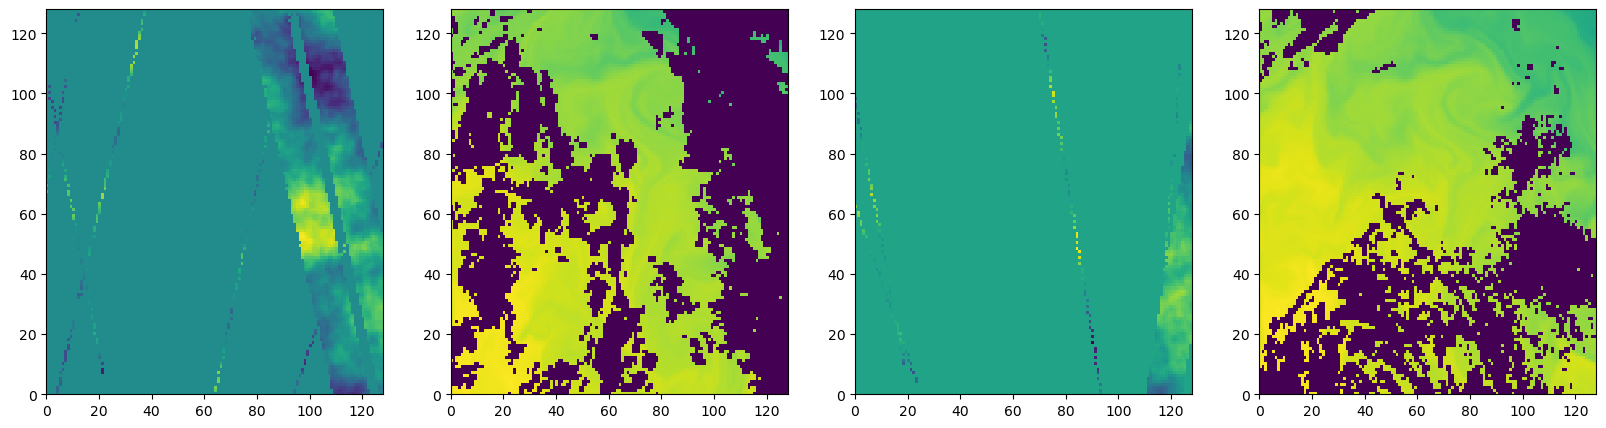

In [36]:
fig, axs = plt.subplots(1,4,figsize=(20,5))
axs[0].pcolor(x_sample[0,0,0])
axs[1].pcolor(x_sample[0,0,1])
axs[2].pcolor(x_sample[0,1,0])
axs[3].pcolor(x_sample[0,1,1])

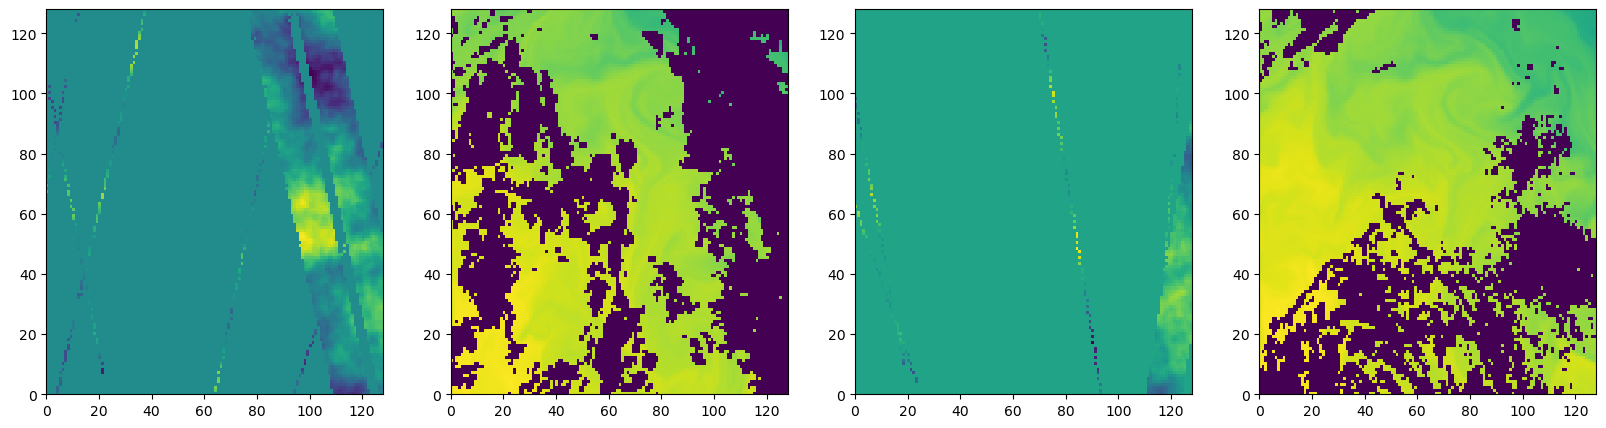

In [37]:
fig, axs = plt.subplots(1,4,figsize=(20,5))
axs[0].pcolor(x2d_nopermute[0,0])
axs[1].pcolor(x2d_nopermute[0,1])
axs[2].pcolor(x2d_nopermute[1,0])
axs[3].pcolor(x2d_nopermute[1,1])

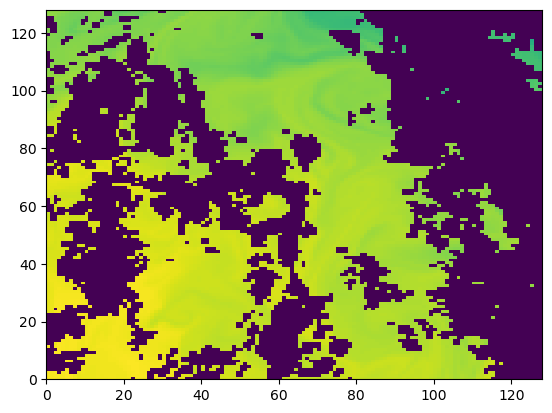

In [38]:
plt.pcolor(x_sample[0,0,1])

In [39]:
test = flatten_bt(x_sample)

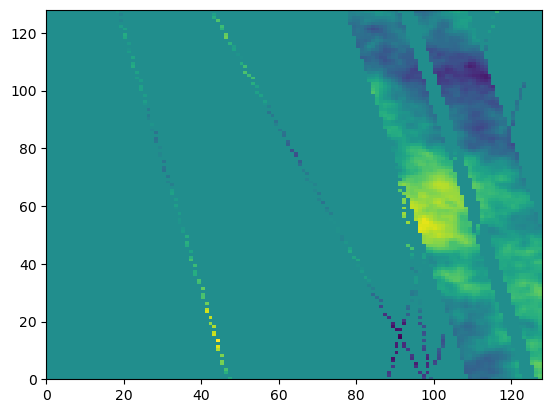

In [40]:
plt.pcolor(test[2,0])

In [41]:
test.shape

torch.Size([50, 2, 128, 128])

In [42]:
B, T, C, H, W = 1, 3, 2, 1, 1
y = torch.zeros(B, T, C, H, W)
y[:, :, 0] = 10  # All t's, channel 0 = 10
y[:, :, 1] = 20  # All t's, channel 1 = 20

print("No permute reshape:")
print(y.reshape(B*T, C, H, W).squeeze())

print("\nPermute + reshape:")
y2d = y.permute(0, 2, 1, 3, 4).contiguous().reshape(B*T, C, H, W)
print(y2d.squeeze())

No permute reshape:
tensor([[10., 20.],
        [10., 20.],
        [10., 20.]])

Permute + reshape:
tensor([[10., 10.],
        [10., 20.],
        [20., 20.]])


In [43]:
B, T, C, H, W = 2, 3, 2, 4, 4
y = torch.zeros(B, T, C, H, W)
y[:,:,0,:,:] = 0  # channel 0
y[:,:,1,:,:] = 1  # channel 1

y2d = y.permute(0, 2, 1, 3, 4).contiguous().reshape(B*T, C, H, W)

for i in range(B*T):
    print(f"Sample {i}, Channel means: {y2d[i].mean(dim=[1,2])}")

Sample 0, Channel means: tensor([0., 0.])
Sample 1, Channel means: tensor([0., 1.])
Sample 2, Channel means: tensor([1., 1.])
Sample 3, Channel means: tensor([0., 0.])
Sample 4, Channel means: tensor([0., 1.])
Sample 5, Channel means: tensor([1., 1.])


In [44]:
y2d_wrong = y.reshape(B*T, C, H, W)
print(y2d_wrong.shape)  # ✅ shape = [6, 2, 4, 4] — but is it correct?
y2d = y.permute(0, 2, 1, 3, 4)  # [B, C, T, H, W]
y2d = y2d.reshape(B*T, C, H, W)

torch.Size([6, 2, 4, 4])


In [45]:
import xarray as xr

# Test SWOT Mask Sampling

In [46]:
DATASET_PATH = cfg.data["dataset_path"] 

In [130]:


for var_name, data_array in worker_generic_swath0.data_vars.items():
    print(f"- {var_name}")
    print(worker_generic_swath0[var_name])

- ssha
<xarray.DataArray 'ssha' (num_lines: 11946, num_pixels: 519)> Size: 50MB
dask.array<open_dataset-ssha, shape=(11946, 519), dtype=float64, chunksize=(1494, 130), chunktype=numpy.ndarray>
Coordinates:
    latitude   (num_lines, num_pixels) float64 50MB dask.array<chunksize=(1494, 130), meta=np.ndarray>
    longitude  (num_lines, num_pixels) float64 50MB dask.array<chunksize=(1494, 130), meta=np.ndarray>
Dimensions without coordinates: num_lines, num_pixels
Attributes:
    comment:        Height of the sea surface anomaly with all corrections ap...
    long_name:      sea surface height anomaly
    standard_name:  sea_surface_height_above_reference_ellipsoid
    units:          m


In [136]:
# Preload SWOT swaths
worker_generic_swath0 = xr.open_zarr(f"{DATASET_PATH}/SWOT_swaths_488/hawaii_c488_p015.zarr")
worker_generic_swath1 = xr.open_zarr(f"{DATASET_PATH}/SWOT_swaths_488/hawaii_c488_p028.zarr")

worker_generic_swath0 = xr.open_zarr(f"{DATASET_PATH}/SWOT_swaths_488/hawaii_c488_p015.zarr")
worker_generic_swath1 = xr.open_zarr(f"{DATASET_PATH}/SWOT_swaths_488/hawaii_c488_p028.zarr")


def get_random_swot_mask(version="random", sampling="all", N=4096, L_x=4096e3, L_y=4096e3, N_t=1,return_ms=False):
    # Helper function to generate a SWOT-like mask
    sw_corner = [-154.5, 34.3]
    ne_corner = [-147.5, 44.3]
    lat_max = None#9000
    lat_min = None#2000
    l_step = 1
    lon = np.random.uniform(sw_corner[0], ne_corner[0])
    lat = np.random.uniform(sw_corner[1], ne_corner[1])
    if version == "random":
        nrand = np.random.randint(2)
        if nrand == 0:
            m0 = interp_utils.grid_everything(worker_generic_swath0.ssha[lat_min:lat_max:l_step,::l_step], lat, lon, n=N, L_x=L_x, L_y=L_y)
        else:
            m0 = interp_utils.grid_everything(worker_generic_swath1.ssha[lat_min:lat_max:l_step,::l_step], lat, lon, n=N, L_x=L_x, L_y=L_y)
        mask = (m0.fillna(0)).values > 0
    elif version == "calval":
        ms = [interp_utils.grid_everything(worker_generic_swath0.ssha[lat_min:lat_max:l_step,::l_step], lat, lon, n=N, L_x=L_x, L_y=L_y),
              interp_utils.grid_everything(worker_generic_swath1.ssha[lat_min:lat_max:l_step,::l_step], lat, lon, n=N, L_x=L_x, L_y=L_y)
             ]
        a0 = np.random.randint(2)
        a1 = int((a0-1)**2)
        if return_ms:
            return ms
        calval_mask = torch.stack([torch.tensor(ms[a0].fillna(0).values > 0), torch.tensor(ms[a1].fillna(0).values > 0)])
        if N_t > 1:
            mask_broadcast = torch.broadcast_to(calval_mask,(N_t//2+N_t%2,2,N,N))
            mask = mask_broadcast.reshape(N_t+N_t%2,N,N)[:N_t]
        else:
            mask = calval_mask[0]
        return mask
    if sampling=="all":
        return torch.tensor(mask)
    elif sampling=="central":
        mask_N_t = torch.zeros([N_t]+list(mask.size()))
        mask_N_t[int(N_t/2),:,:] = mask
        return torch.tensor(mask_N_t)
    elif sampling=="random":
        mask_N_t = torch.zeros([N_t]+list(mask.size()))
        mask_N_t[np.random.nandint(N_t),:,:] = mask
        return torch.tensor(mask_N_t)



In [185]:
def get_random_swot_mask(version="random", sampling="all", N=4096, L_x=4096e3, L_y=4096e3, N_t=1,return_ms=False):
    # Helper function to generate a SWOT-like mask
    sw_corner = [-154.5, 34.3]
    ne_corner = [-147.5, 44.3]
    lat_max = None#9000
    lat_min = None#2000
    l_step = 1
    lon = np.random.uniform(sw_corner[0], ne_corner[0])
    lat = np.random.uniform(sw_corner[1], ne_corner[1])
    if version == "random":
        nrand = np.random.randint(2)
        if nrand == 0:
            m0 = interp_utils.grid_everything(worker_generic_swath0.ssha[lat_min:lat_max:l_step,::l_step], lat, lon, n=N, L_x=L_x, L_y=L_y)
        else:
            m0 = interp_utils.grid_everything(worker_generic_swath1.ssha[lat_min:lat_max:l_step,::l_step], lat, lon, n=N, L_x=L_x, L_y=L_y)
        mask = (m0.fillna(0)).values > 0
    elif version == "calval":
        ms = [interp_utils.grid_everything(worker_generic_swath0.ssha[lat_min:lat_max:l_step,::l_step], lat, lon, n=N, L_x=L_x, L_y=L_y),
              interp_utils.grid_everything(worker_generic_swath1.ssha[lat_min:lat_max:l_step,::l_step], lat, lon, n=N, L_x=L_x, L_y=L_y)
             ]
    return ms

In [186]:
random_masks = []
for i in range(1):
    print(i,end=", ")
    random_masks.append(get_random_swot_mask(version="calval",N_t=2))
random_masks = np.asarray(random_masks)

0, 

In [187]:
random_masks

array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]])

In [141]:
random_masks.shape

(1, 6, 4096, 4096)

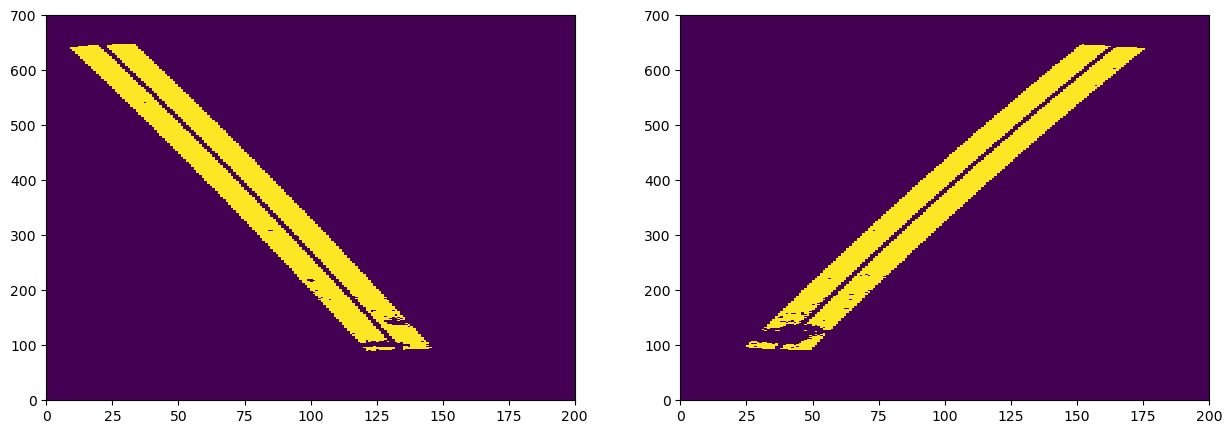

In [155]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].pcolor(random_masks[0,0,50*5:750*5:5,300*5:500*5:5])
axs[1].pcolor(random_masks[0,1,50*5:750*5:5,300*5:500*5:5])

In [160]:
np.save("SWOT_masks_1km", random_masks[0,:2,50*5:750*5:5,300*5:500*5:5])

In [66]:
swot_npy_mask = np.stack([random_masks[i,0][50:850,350:600],random_masks[i,1][50:850,325:575]])

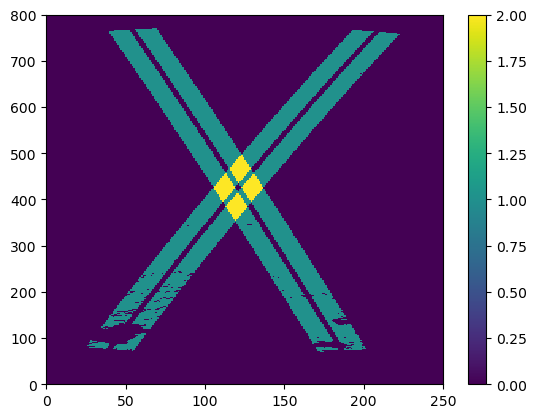

In [181]:
plt.pcolor(swot_npy_mask.sum(axis=0))
plt.colorbar()

In [79]:
swot_npy_mask.shape

(2, 800, 250)

In [93]:
np.save('swot_npy_mask_4km.npy', swot_npy_mask)



69 247


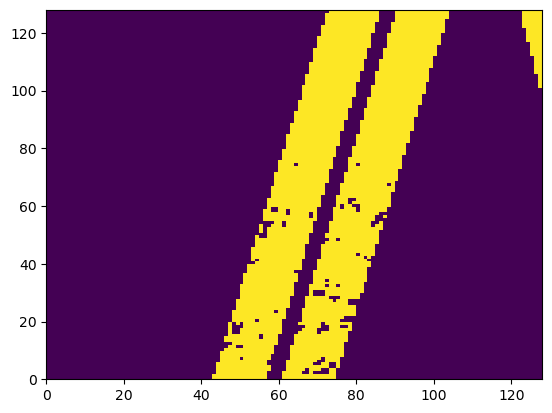

129 197


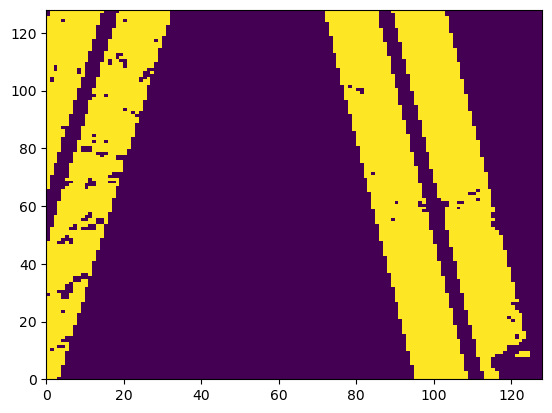

107 240


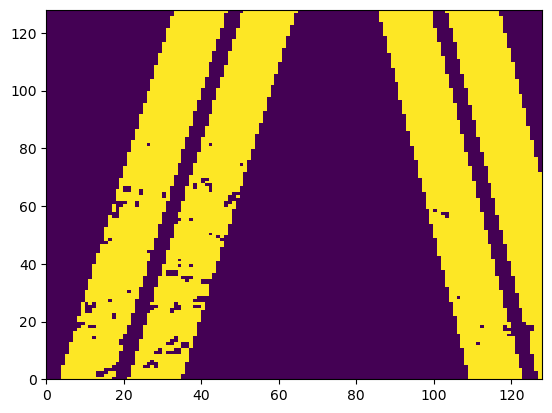

149 256


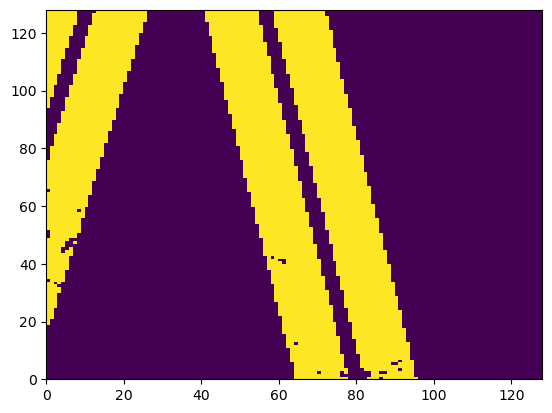

75 414


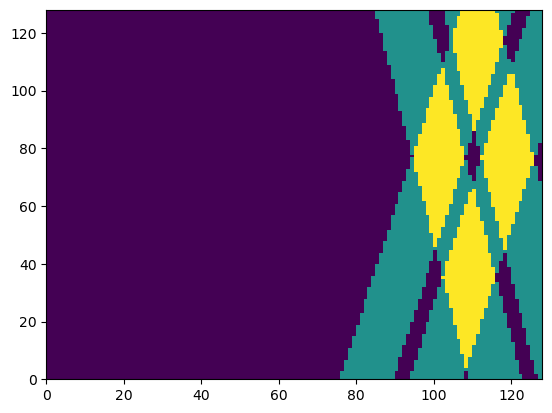

158 213


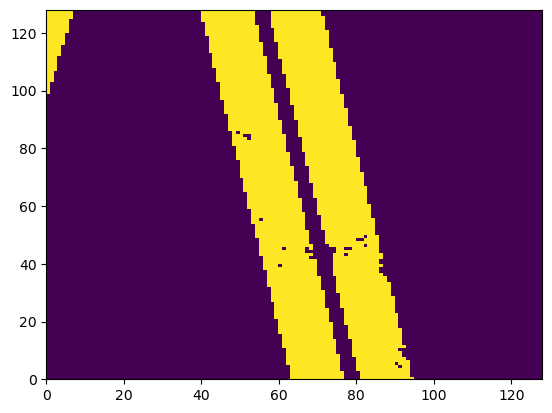

70 490


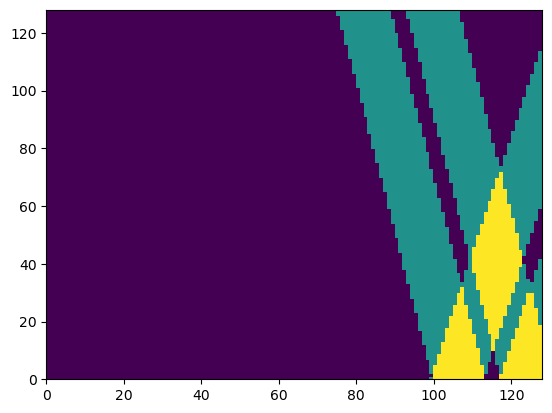

154 436


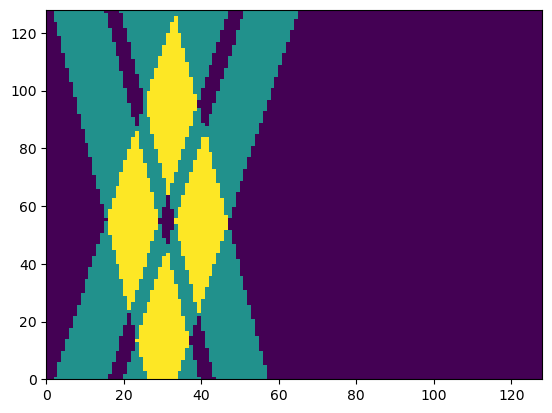

90 647


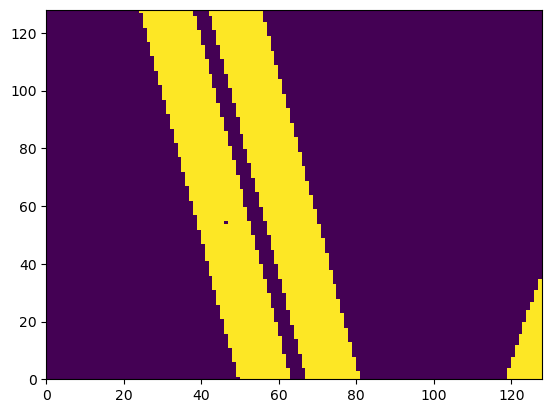

155 469


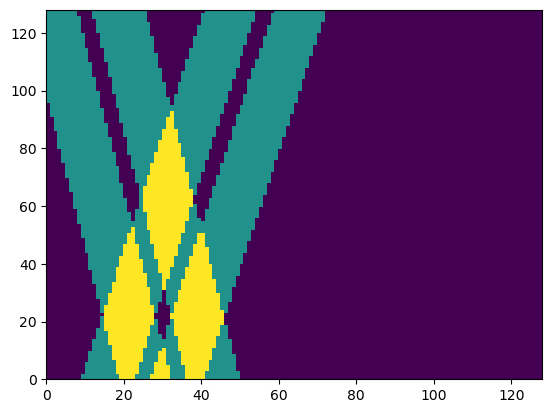

In [92]:

for i in range(10):
    i_rand = int(np.random.uniform(64,225-64))
    j_rand = int(np.random.uniform(128,800-64))
    print(i_rand,j_rand)
    test = swot_npy_mask[:,j_rand-64:j_rand+64,i_rand-64:i_rand+64]*1
    
    plt.pcolor(test.sum(axis=0))
    plt.show()
    plt.close()

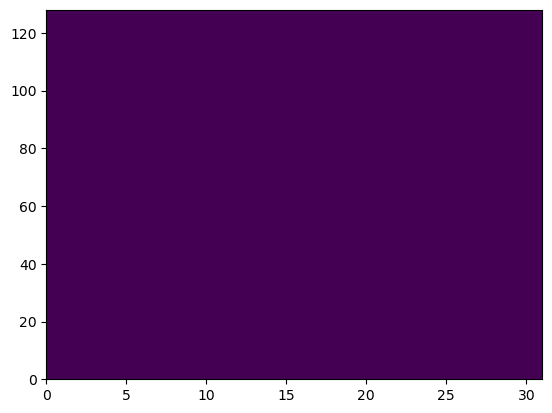

In [54]:
datasets = []
for file in glob.glob("/home/tm3076/scratch/SWOT_L3_v2_0_1/Unsmoothed_North_Pacific/cycle_008/*"):
    try:
        datasets.append(xr.open_dataset(file))
    except Exception as e:
        print(f"Could not open {file}")
        print(f"{e}")

Could not open /home/tm3076/scratch/SWOT_L3_v2_0_1/Unsmoothed_North_Pacific/cycle_008/SWOT_L3_LR_SSH_Unsmoothed_008_005_20231214T101554_20231214T110633_v2.0.1.nc
[Errno -101] NetCDF: HDF error: '/home/tm3076/scratch/SWOT_L3_v2_0_1/Unsmoothed_North_Pacific/cycle_008/SWOT_L3_LR_SSH_Unsmoothed_008_005_20231214T101554_20231214T110633_v2.0.1.nc'


In [55]:
center_latlon = np.asarray([(-154.5-147.5)/2,(34.3+44.3)/2])
center_latlon

array([-151. ,   39.3])